# Project Configuration

## Libraries Installation:

Please, install the libraries below in your development environment.

- !pip install seaborn
- !pip install scipy
- !pip install numpy
- !pip install pandas
- !pip install matplotlib
- !pip install requests
- !pip install nltk
- !pip install wordcloud
- !pip install -U scikit-learn
- !pip install pydantic-settings
- !pip install ydata-profiling
- !pip install --upgrade gensim
- !pip install pyldavis

## Setting variables and libraries

- collect_data: True means to conduct an API call to get the data, and False means to use the already collected data in CSV files. If collect_data equals True, you must get an API key from TMDB using the link provided and set the API_TMDB_TOKEN env var using that key.
- run_lda_training: True means run the training, which takes time; False means to take the visualization result from the already generated HTML (ida_visualization_overview.html)
- create_pandas_profiling: True means create the profile, which takes some time. False means you will inspect the one already generated in Report.html.

In [1]:
# configuration variables
collect_data = False
run_lda_training = False
create_pandas_profiling = False

In [2]:
# Import libraries
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import numpy as np
import ast
import csv
import os
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import gensim
import nltk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pyLDAvis import gensim
from gensim import corpora
from gensim import models
from IPython.display import display, HTML
from wordcloud import WordCloud
import string

/Users/marygomez/Lambton_projects/advanced_python_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/marygomez/Lambton_projects/advanced_python_project/venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/marygomez/Lambton_projects/advanced_python_project/venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is 

In [3]:
warnings.filterwarnings('ignore')

# Step 1

## Data Collection

The data used in this report was pulled from TMDB (https://www.themoviedb.org) using their public API. To be able to use the API, we created a user and sent a GET request to the authentications endpoint (https://api.themoviedb.org/3/authentication). By doing this, we were able to confirm proper client setup. Furthermore, we conducted GET requests to the endpoint (https://api.themoviedb.org/3/discover/movie) to get as many records as possible. We stored those records in CSV format.

The data collected has the following features:

GenreIds: This is a list of different genres applicable to the movie. The map between genre id and genre is below:

- Action          28
- Adventure       12
- Animation       16
- Comedy          35
- Crime           80
- Documentary     99
- Drama           18
- Family          10751
- Fantasy         14
- History         36
- Horror          27
- Music           10402
- Mystery         9648
- Romance         10749
- Science Fiction 878
- TV Movie        10770
- Thriller        53
- War             10752
- Western         37

Id: this is the unique identifier for each movie
OriginalLanguage: The movie's original language
OriginalTitle: The movie's title
Overview: short description of the movie content
Popularity: it is a metric used to measure how popular the movie is, it takes into account the following aspects

- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favorite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

ReleaseDate: movie data of release
Title: title of the movie
VoteAverage: It's the average of all of the TMDb user ratings
VoteCount: number of people who voted for the movie

In [4]:
# Checking API Authentication

if collect_data:
    api_token = os.environ['API_TMDB_TOKEN']

    url = "https://api.themoviedb.org/3/authentication"

    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {api_token}"
    }

    response = requests.get(url, headers=headers)

    print(response.text)

In [5]:
# Funtions to handle the data retrieval

def create_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['GenreIds'] = movie.get('genre_ids', None)
        result['Id'] = movie.get('id', None)
        result['OriginalLanguage'] = movie.get('original_language', None)
        result['OriginalTitle'] = movie.get('original_title', None)
        result['Overview'] = movie.get('overview', None)
        result['Popularity'] = movie.get('popularity', None)
        result['ReleaseDate'] = movie.get('release_date', None)
        result['Title'] = movie.get('title', None)
        result['VoteAverage'] = movie.get('vote_average', None)
        result['VoteCount'] = movie.get('vote_count', None)
        movies.append(result)
        result = {}
    return movies

def store_in_CSV(file_name, posts, fields):
    '''This function stores a list of dictionaries in CSV format'''
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def retrive_movies_data(headers):
    '''This function retrieves data form the /discover endpoint and process it into a CSV file'''
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&sort_by=popularity.desc"
    fields = ['GenreIds', 'Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount']

    while True:
        final_url = url + f"&page={page}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        data = json_res.get("results", [])
        if len(data) == 0:
            break
        dic_data = create_dict(data)
        page += 1
        store_in_CSV('movies.csv',dic_data, fields)

def create_movie_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['Id'] = movie.get('id', None)
        result['Budget'] = movie.get('budget', None)
        result['ProductionCompanies'] = movie.get('production_companies', None)
        result['ProductionCountries'] = movie.get('production_countries', None)
        result['SpokenLanguages'] = movie.get('spoken_languages', None)
        result['TagLine'] = movie.get('tagline', None)
        result['RunTime'] = movie.get('runtime', None)
        result['Revenue'] = movie.get('revenue', None)
        movies.append(result)
        result = {}
    return movies


def get_data_by_id(headers, ids):
    '''This function retrieves data form the /movie/id endpoint and process it into a CSV file'''
    url = 'https://api.themoviedb.org/3/movie/'
    fields = ['Id', 'Budget', 'ProductionCompanies', 'ProductionCountries', 'SpokenLanguages', 'TagLine', 'RunTime', 'Revenue']
    all_movies = []

    for id in ids:
        final_url = url + f"{id}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        all_movies.append(json_res)
    dic_data = create_movie_dict(all_movies)
    store_in_CSV('movie_details.csv',dic_data, fields)

In [6]:
# running this function creates a movies.csv in the same folder
if collect_data:
    retrive_movies_data(headers)

In [7]:
# Initial Dataset review
df_init = pd.read_csv('movies.csv')
print(df_init.shape)
df_init.head()

(10000, 10)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686


In [8]:
# getting the list of movie ids
ids = list(df_init['Id'])

In [9]:
# getting second dataset with movie details
if collect_data:
    get_data_by_id(headers, ids)

In [10]:
# Checking movie details data

df_movies = pd.read_csv('movie_details.csv')
print(df_movies.shape)
df_movies.head()

(10000, 8)


,Id,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,299054,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,926393,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,1034062,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,575264,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'French', 'iso_639_1': 'fr',...",We all share the same fate.,164,567148955
4,1151534,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]","[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Attempting to survive in the middle of nowhere...,109,0


# Step 2

## Data Wrangling

In this section, we conducted several steps to clean up and prepare the data for analysis. The steps we followed are listed below:

1. Merge data sets: So far, we have two CSV files, one with overall movie information and one with detailed movie data. We wanted to merge these two datasets using the movie "Id" as the primary key.
2. Features and datatypes: In this steps we will process features into the proper data type, inspecting and correcting invalid values
3. Inspect and impute nulls
4. Inspect and correct duplicated rows
5. Text Wrangling
6. create a new cleaned dataset (movies_cleaned.csv)



### 1. Merge Datasets

In [11]:
def inner_join(df1, df2, pk):
    '''This methods performs inner joint, based on given primery key'''
    return pd.merge(df1, df2, on=pk)

In [12]:
# Perform inner join to consolidate one single dataset
df = inner_join(df_init, df_movies, 'Id')
print(df.shape)
df.head(1)

(10000, 17)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000


### 2. Features and datatypes:

In [13]:
# create a list with the columns of the Dataframe
columns = df.columns

In [14]:
# Review the dataframe datatypes

df.dtypes

GenreIds                object
Id                       int64
OriginalLanguage        object
OriginalTitle           object
Overview                object
Popularity             float64
ReleaseDate             object
Title                   object
VoteAverage            float64
VoteCount                int64
Budget                   int64
ProductionCompanies     object
ProductionCountries     object
SpokenLanguages         object
TagLine                 object
RunTime                  int64
Revenue                  int64
dtype: object

In [16]:
# categorical columns inspection

categorical_df = df.select_dtypes(include='object')
categorical_df.head(1)

,GenreIds,OriginalLanguage,OriginalTitle,Overview,Title,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine
0,"[28, 12, 53]",en,Expend4bles,Armed with every weapon they can get their han...,Expend4bles,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.


In [17]:
# reviewing unique values in each category to stablish category relevancy, text columns excluded to process in further steps

categorical_columns = categorical_df.columns
text_columns = ['Overview', 'Title', 'OriginalTitle', 'TagLine']

for column in categorical_columns:
    if column not in text_columns:
        print(f"----Unique values for column {column} -----")
        print(categorical_df[column].unique()[:5])

----Unique values for column GenreIds -----
['[28, 12, 53]' '[28, 53, 80]' '[16, 28, 14]' '[28, 53]' '[53, 18]']
----Unique values for column OriginalLanguage -----
['en' 'es' 'ko' 'hi' 'de']
----Unique values for column ProductionCompanies -----
["[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLghDhhZJzHZTd.png', 'name': 'Millennium Media', 'origin_country': 'US'}, {'id': 48738, 'logo_path': None, 'name': 'Campbell Grobman Films', 'origin_country': 'US'}, {'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0xjq7ST9cH0.png', 'name': 'Lionsgate', 'origin_country': 'US'}]"
 "[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6HWEn1YqfAV.png', 'name': 'Escape Artists', 'origin_country': 'US'}, {'id': 5, 'logo_path': '/wrweLpBqRYcAM7kCSaHDJRxKGOP.png', 'name': 'Columbia Pictures', 'origin_country': 'US'}, {'id': 10400, 'logo_path': '/9LlB2YAwXTkUAhx0pItSo6pDlkB.png', 'name': 'Eagle Pictures', 'origin_country': 'IT'}, {'id': 44967, 'logo_path': None, 'name': 'ZHIV Productions', 'origin_country': ''}]"
 "[{'i

In [18]:
# eliminate SpokenLanguages as there is already a column for original language and we believe the translations may not be predictive to the model
df.drop('SpokenLanguages', axis=1, inplace=True)

In [19]:
# preprocessing of column 'GenreIds'

# dictionaty to map genre ids to genre names
genre_map = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History ',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'ScienceFiction',
    10770: 'TvMovie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}

In [20]:
# GenreIds Column, will be tranformed to a textual column to be used later

df['GenreIds'] = df['GenreIds'].apply(ast.literal_eval)

# Function to map genre IDs to genre names
def map_genre_ids_to_names(genre_ids):
    return [genre_map[genre_id] for genre_id in genre_ids]

# Apply the mapping function to the 'GenreIds' column
df['Genres'] = df['GenreIds'].apply(map_genre_ids_to_names)

In [21]:
df['Genres'] = df['Genres'].apply(lambda x: ', '.join(x))
df['Genres'].head(2)

0    Action, Adventure, Thriller
1        Action, Thriller, Crime
Name: Genres, dtype: object

In [22]:
# dropping the GenreIds
df.drop('GenreIds', axis=1, inplace=True)

Processing of ProductionCompanies and ProductionCountries

In [23]:
# Function create a mapping object
def get_feature_mapper(df, column):
    '''This functions creates an object to map the categorical name to the rows'''
    result = {}
    for i in range(len(df)):
        items = ast.literal_eval(df.loc[i, column])
        for item in items:
            name = item['name']
            if name in result.keys():
                result[name].append(i)
            else:
                result[name] = []
    return result



In [24]:
# checking the cardinality for the column ProductionCompanies
prod_comp_map = get_feature_mapper(df, 'ProductionCompanies')
len(prod_comp_map.keys())

9980

The cardinality for the column ProductionCompanies is high, with 9980 different production companies. Therefore, we won't consider this column as it might not be discriminative enough.

In [25]:
# eliminating the column ProductionCompanies
df.drop('ProductionCompanies', axis=1, inplace=True)

In [26]:
# checking the cardinality for the column ProductionCountries
prod_contries_map = get_feature_mapper(df, 'ProductionCountries')
len(prod_contries_map.keys())

107

In [27]:
prod_contries_map.keys()

dict_keys(['United States of America', 'Italy', 'Spain', 'South Korea', 'China', 'India', 'Canada', 'France', 'Australia', 'United Kingdom', 'Germany', 'Brazil', 'Mexico', 'Japan', 'Russia', 'Sweden', 'United Arab Emirates', 'Nigeria', 'Poland', 'Serbia', 'Ukraine', 'Thailand', 'Finland', 'Norway', 'Switzerland', 'Bangladesh', 'Austria', 'Kazakhstan', 'Belgium', 'Hong Kong', 'Cyprus', 'Greece', 'Denmark', 'Ireland', 'New Zealand', 'Chile', 'Philippines', 'Singapore', 'Taiwan', 'Puerto Rico', 'Iceland', 'Argentina', 'Czech Republic', 'Colombia', 'Peru', 'Bulgaria', 'Netherlands', 'Hungary', 'South Africa', 'Latvia', 'Dominican Republic', 'Uruguay', 'Venezuela', 'Malta', 'Turkey', 'Saudi Arabia', 'Portugal', 'Morocco', 'Slovenia', 'Israel', 'Luxembourg', 'Indonesia', 'Panama', 'Bolivia', 'Romania', 'Guadaloupe', 'Iran', 'Costa Rica', 'Honduras', 'Albania', 'Jordan', 'Pakistan', 'Lithuania', 'Vietnam', 'Malawi', 'Soviet Union', 'Estonia', 'Botswana', 'Paraguay', 'Yugoslavia', 'Georgia', '

The column ProductionCountries had high cardinality (107). On the other hand, we considered this column to be meaningful to the model. Therefore, we decided to reduce the number of columns by creating groups of production countries based on continents.

In [28]:
country_region = {
    'United States of America': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'South Korea': 'Asia',
    'China': 'Asia',
    'India': 'Asia',
    'Canada': 'North America',
    'France': 'Europe',
    'Australia': 'Oceania',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'Brazil': 'South America',
    'Mexico': 'North America',
    'Japan': 'Asia',
    'Russia': 'Europe',
    'Sweden': 'Europe',
    'United Arab Emirates': 'Asia',
    'Nigeria': 'Africa',
    'Poland': 'Europe',
    'Serbia': 'Europe',
    'Ukraine': 'Europe',
    'Thailand': 'Asia',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Bangladesh': 'Asia',
    'Austria': 'Europe',
    'Kazakhstan': 'Asia',
    'Belgium': 'Europe',
    'Hong Kong': 'Asia',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'New Zealand': 'Oceania',
    'Chile': 'South America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Taiwan': 'Asia',
    'Puerto Rico': 'North America',
    'Iceland': 'Europe',
    'Argentina': 'South America',
    'Czech Republic': 'Europe',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bulgaria': 'Europe',
    'Netherlands': 'Europe',
    'Hungary': 'Europe',
    'South Africa': 'Africa',
    'Latvia': 'Europe',
    'Dominican Republic': 'North America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Malta': 'Europe',
    'Turkey': 'Asia',
    'Saudi Arabia': 'Asia',
    'Portugal': 'Europe',
    'Morocco': 'Africa',
    'Slovenia': 'Europe',
    'Israel': 'Asia',
    'Luxembourg': 'Europe',
    'Indonesia': 'Asia',
    'Panama': 'North America',
    'Bolivia': 'South America',
    'Romania': 'Europe',
    'Guadaloupe': 'North America',
    'Iran': 'Asia',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Pakistan': 'Asia',
    'Lithuania': 'Europe',
    'Vietnam': 'Asia',
    'Malawi': 'Africa',
    'Soviet Union': 'Europe',
    'Estonia': 'Europe',
    'Botswana': 'Africa',
    'Paraguay': 'South America',
    'Yugoslavia': 'Europe',
    'Georgia': 'Asia',
    'Slovakia': 'Europe',
    'Malaysia': 'Asia',
    'Mauritius': 'Africa',
    'Guatemala': 'North America',
    'Macao': 'Asia',
    'Jamaica': 'North America',
    'Lebanon': 'Asia',
    'Qatar': 'Asia',
    'Zimbabwe': 'Africa',
    'Egypt': 'Africa',
    'Senegal': 'Africa',
    'Czechoslovakia': 'Europe',
    'East Germany': 'Europe',
    'Kenya': 'Africa',
    'Solomon Islands': 'Oceania',
    'Cambodia': 'Asia',
    'Iraq': 'Asia',
    'Tunisia': 'Africa',
    'Ecuador': 'South America',
    'Croatia': 'Europe',
    'Liechtenstein': 'Europe',
    'Namibia': 'Africa',
    'Ghana': 'Africa',
    'Bahamas': 'North America',
    'Aruba': 'North America',
    'Moldova': 'Europe'
}

In [29]:
# we modified the mapping dictionary with the continent instead of the country
new_prod_contries_map = {}
for country in prod_contries_map.keys():
    continent = country_region[country]
    if continent in new_prod_contries_map.keys():
        new_prod_contries_map[continent] += prod_contries_map[country]
    else:
        new_prod_contries_map[continent]  = prod_contries_map[country]

Using this strategy, we were able to reduce the cardinality for ProductionCountries from 107 to 6

In [30]:
prod_places_columns = list(new_prod_contries_map.keys())
prod_places_columns

['North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']

In [31]:
# create new columns in the dataframe with initial zero values

df[prod_places_columns] = 0

In [32]:
# updating the values in each new column using the new_prod_contries_map

def update_continent_columns(new_prod_contries_map):
    '''update the data frame prod continent columns'''
    for con in new_prod_contries_map.keys():
        indexes = new_prod_contries_map[con]
        for i in indexes:
            df.loc[i, con] = 1


In [33]:
# update the continent columns
update_continent_columns(new_prod_contries_map)

In [34]:
# checking resulting columns
df[prod_places_columns].head()

,North America,Europe,Asia,Oceania,South America,Africa
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


In [35]:
# dropping the ProductionCountries column
df.drop('ProductionCountries', axis=1, inplace=True)

In [36]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

The column OriginalLanguage presents a high cardinality of 50; we looked to reduce this cardinality.

In [37]:
# calculate OriginalLanguage cardinality
len(df['OriginalLanguage'].unique())

50

In [38]:
# understanding then column
df['OriginalLanguage'].head(5)

0    en
1    en
2    en
3    en
4    es
Name: OriginalLanguage, dtype: object

In [39]:
ol_df = df.groupby('OriginalLanguage')[['Id']].count()
ol_df.head(1)

,Id
OriginalLanguage,
ar,5


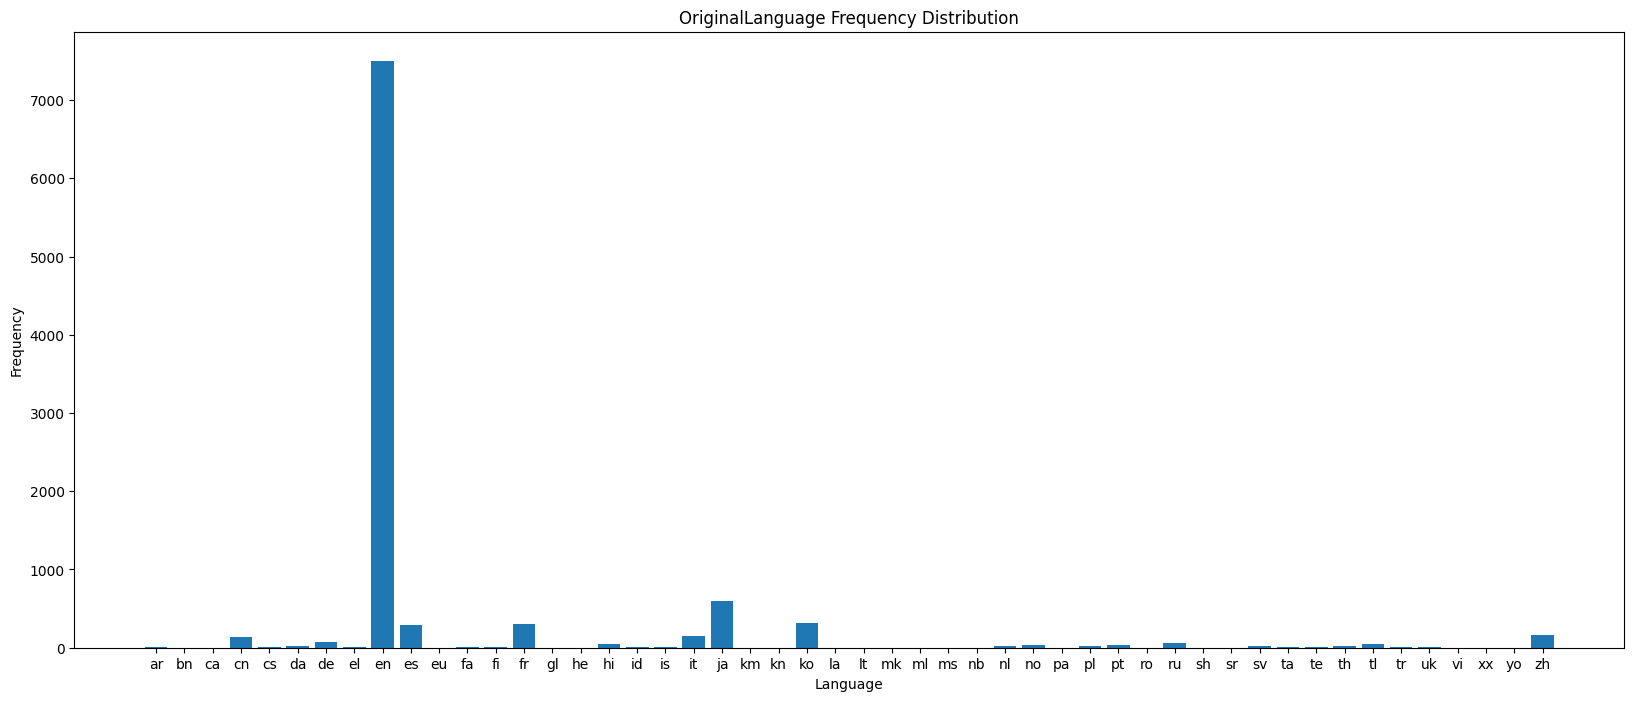

In [40]:
# Visualizing category distribution for original language
plt.figure(figsize=(20, 8))
plt.bar(ol_df.index, ol_df['Id'])
plt.title('OriginalLanguage Frequency Distribution')
plt.ylabel('Frequency')
plt.xlabel('Language')
plt.show()

As can be seen, English 'en' has a considerable share compared to other languages. Therefore, we are going to limit this to two categories only, English and not_english

In [41]:
# method to transform OriginalLanguage
def replace_language(item):
    '''function to replace the original language by a binary form'''
    if item == 'en':
        return 1
    else:
        return 0

In [42]:
df['OriginalLanguage'] = df['OriginalLanguage'].apply(replace_language)

Note: In this second section, we discovered the data separating numerical from categoricals, then applied different strategies to transform the categoricals from plain text to numerical values; we had to use some assumptions to reduce the cardinality in some of the categorical data.

### 3. Inspect and impute nulls

In [43]:
#checking number of nulls by column
df.isna().sum()

Id                     0
OriginalLanguage       0
OriginalTitle          0
Overview              51
Popularity             0
ReleaseDate           21
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             2413
RunTime                0
Revenue                0
Genres                 0
North America          0
Europe                 0
Asia                   0
Oceania                0
South America          0
Africa                 0
dtype: int64

In [44]:
# TagLine nulls will be replaced to empty string throughout the code.
df['TagLine'].fillna('', inplace=True)

In [45]:
# Remove other nulls in ReleaseDate and Overview, there are just 72 records and there is not a reasonable way to impute those

df.dropna(inplace=True)

In [46]:
#checking number of nulls by column
df.isna().sum()

Id                  0
OriginalLanguage    0
OriginalTitle       0
Overview            0
Popularity          0
ReleaseDate         0
Title               0
VoteAverage         0
VoteCount           0
Budget              0
TagLine             0
RunTime             0
Revenue             0
Genres              0
North America       0
Europe              0
Asia                0
Oceania             0
South America       0
Africa              0
dtype: int64

### 4. Inspect and correct duplicated rows

In [47]:
df.duplicated().sum()

0

Note: There were not duplicated rows

### 5. Text Wrangling

#### Checking Language

In [48]:
# checking textual data for non english columns
df[df['OriginalLanguage'] == 0][['OriginalTitle', 'Title', 'Overview', 'TagLine']]

,OriginalTitle,Title,Overview,TagLine
4,Nowhere,Nowhere,A young pregnant woman named Mia escapes from ...,Attempting to survive in the middle of nowhere...
6,발레리나,Ballerina,Grieving the loss of a best friend she couldn'...,"Merciless and ruthless, to hell."
11,Uri: The Surgical Strike,Uri: The Surgical Strike,Following the roguish terrorist attacks at Uri...,
26,Duell am Abgrund,Race to the Summit,Fearless alpine climbers Ueli Steck and Dani A...,
27,Carga Máxima,Overhaul,"When truck racer Roger loses everything, he re...",Removing your foot is not an option.
...,...,...,...,...
9987,Été 85,Summer of 85,What do you dream of when you're 16-years-old ...,
9989,అల వైకుంఠపురములో,Ala Vaikunthapurramuloo,Fate plays a vital role in connecting the life...,
9993,Dear Zindagi,Dear Zindagi,An unconventional thinker helps a budding cine...,
9994,Largo Winch,The Heir Apparent: Largo Winch,"After a powerful billionaire is murdered, his ...",


In [50]:
#Filtering out OriginalTitle as it contains other languages and Title is the same column but in english
df.drop(columns=['OriginalTitle'], inplace=True)

#### Remove punctuations, numbers and stop words

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marygomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
# Method to clean textual data
eng_stop_words = stopwords.words('english')
def process_text(text):
    """
    Process a string to remove stop words
    """
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize and remove stop words
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() not in eng_stop_words and not word.isnumeric()]
    return " ".join(filtered_words)

In [53]:
# Processing the columns: 'Overview', 'Title', 'Genres

df['Overview'] = df['Overview'].apply(process_text)
df['Title'] = df['Title'].apply(process_text)
df['Genres'] = df['Genres'].apply(process_text)
df['TagLine'] = df['TagLine'].apply(process_text)

In [54]:
# after cleaning, title ended up with some empty strings
# We need to remove this rows as those will be parsed as nulls when imported
indexes_to_remove = df[df['Title'] == ''].index

In [55]:
df.drop(indexes_to_remove, inplace=True)

In [56]:
# checking empty string in Genres
len(df[df['Genres'] == ''].index)

49

In [58]:
# dropping nulls in 'Genres'
indexes_to_remove = df[df['Genres'] == ''].index
df.drop(indexes_to_remove, inplace=True)

In [59]:
# checking empty string in Overview
len(df[df['Overview'] == ''].index)

0

In [60]:
# No nulls in Dataset
df.isna().sum()

Id                  0
OriginalLanguage    0
Overview            0
Popularity          0
ReleaseDate         0
Title               0
VoteAverage         0
VoteCount           0
Budget              0
TagLine             0
RunTime             0
Revenue             0
Genres              0
North America       0
Europe              0
Asia                0
Oceania             0
South America       0
Africa              0
dtype: int64

### 6. Create new cleaned dataset (movies_cleaned.csv)

In [61]:
# store final clearned dataset in CSV

df.to_csv('movies_cleaned.csv', index=False)

# Step 3

## Text Data Visualizations

In [63]:
# Reading cleaned data
data = pd.read_csv('movies_cleaned.csv', lineterminator='\n', index_col='Id')

In [65]:
data.head(2)


,OriginalLanguage,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa
Id,,,,,,,,,,,,,,,,,,
299054,1,armed every weapon get hands skills use expend...,3741.062,2023-09-15,expend4bles,6.4,364,100000000,theyll die theyre dead,103,30000000,action adventure thriller,0,0,0,0,0,0
926393,1,robert mccall finds home southern italy discov...,2471.515,2023-08-30,equalizer,7.3,1027,70000000,justice knows borders,109,176933602,action thriller crime,1,0,0,0,0,0


In [66]:
# empty string in TagLine is parced as nulls when importing as csv, those are corrected before analysis
data['TagLine'].fillna('', inplace=True)

### Words Cloud

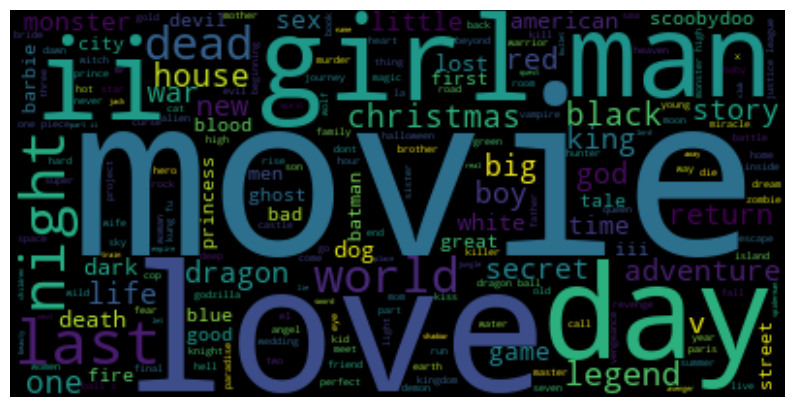

In [67]:
# Words Cloud Title
text = ' '.join(data['Title'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

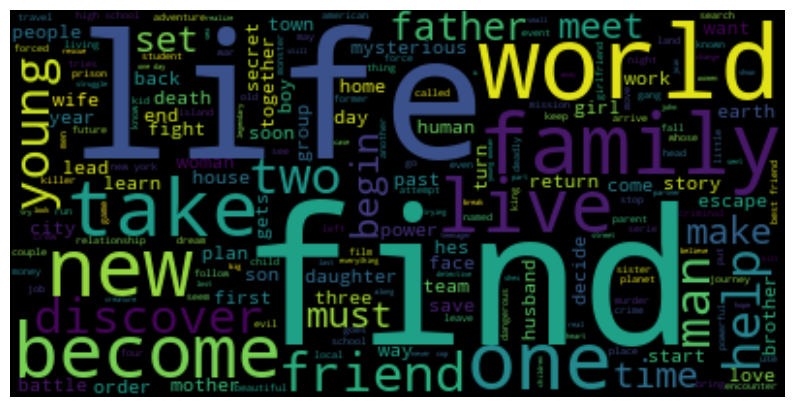

In [68]:
# Words Cloud Overview
text = ' '.join(data['Overview'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

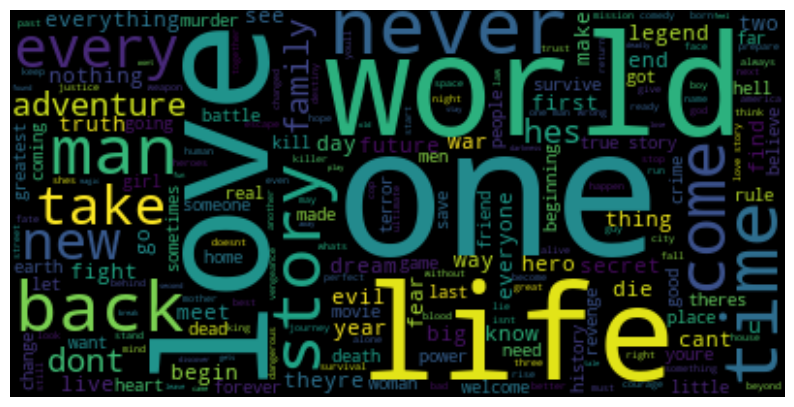

In [69]:
# Words Cloud TagLine
text = ' '.join(data['TagLine'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Note: The Word Clouds shows that positive words are more frequent than negative words in either Overview or Title. For instance, we see words like Love, life, friend, and family. However, We can see some negative terms, too, such as bad, evil, and lost.

### Top Words

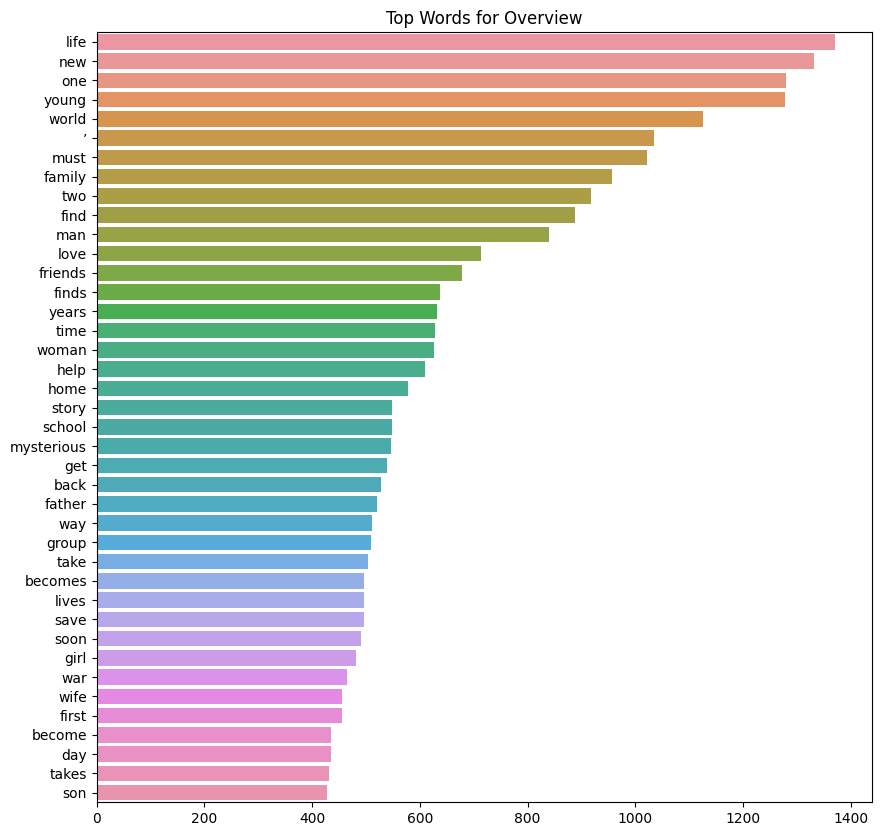

In [70]:
def plot_top_words_barchart(text, column):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        x.append(word)
        y.append(count)

    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    plt.title(f'Top Words for {column}')

plot_top_words_barchart(data['Overview'], 'Overview')

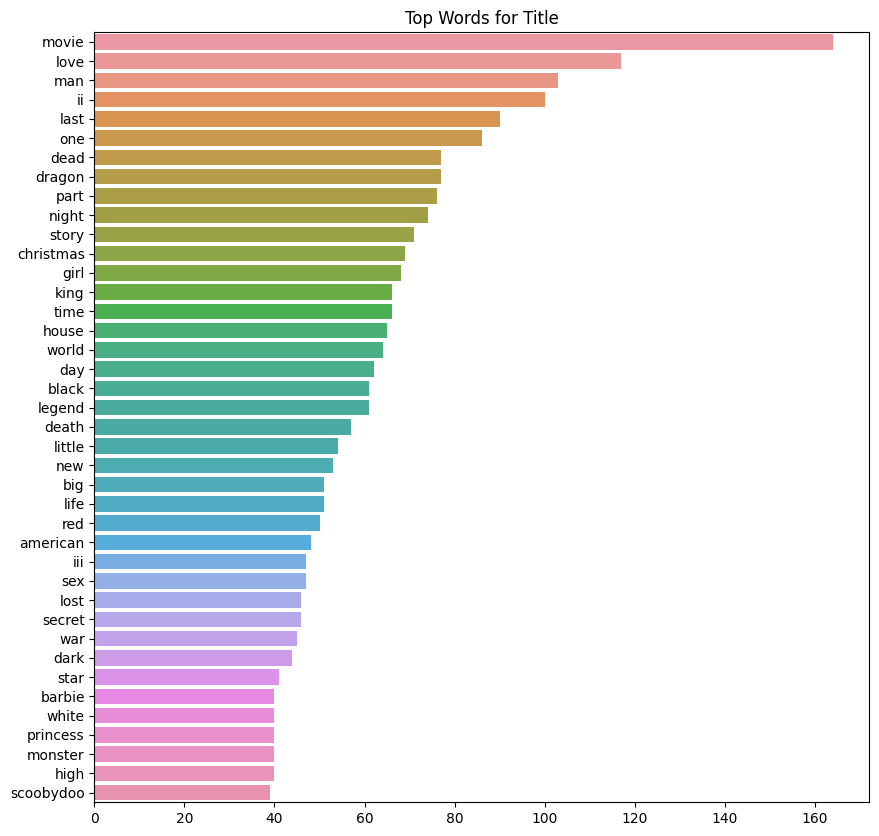

In [71]:
plot_top_words_barchart(data['Title'], 'Title')

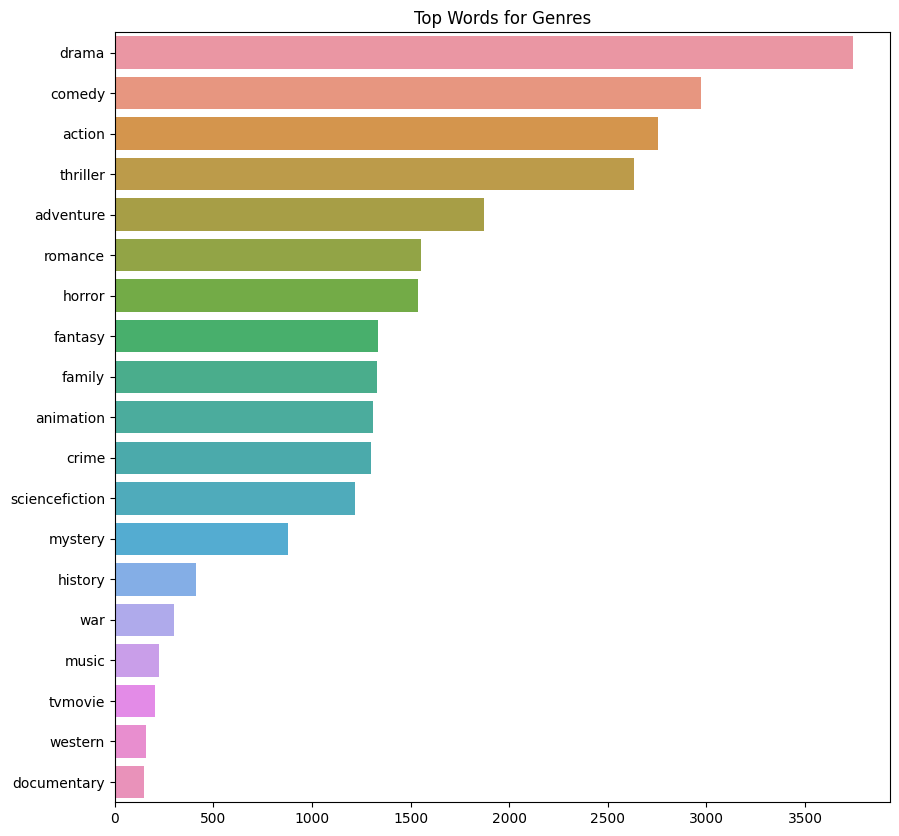

In [72]:
plot_top_words_barchart(data['Genres'], 'Genres')

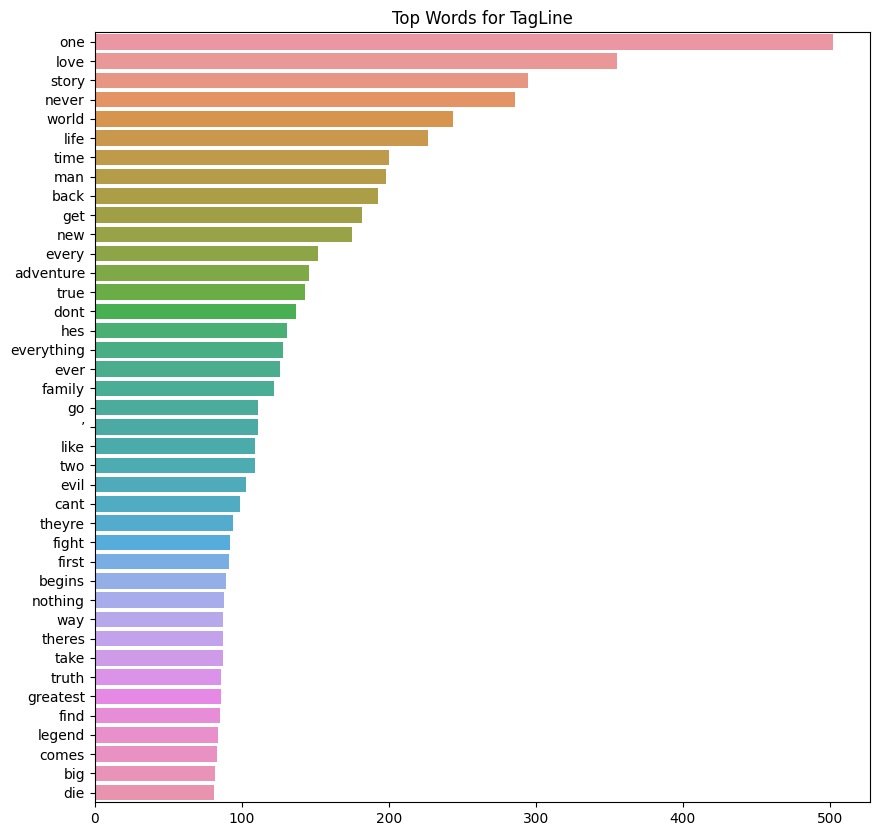

In [73]:
plot_top_words_barchart(data['TagLine'], 'TagLine')

Note: We identfied thanks to the previous graph, the top most frequent words for overview and title are generaly posititive and neutral nature. In tems of genres, we see drama in the top, followed by comedy and thriller.

### Top n-grams

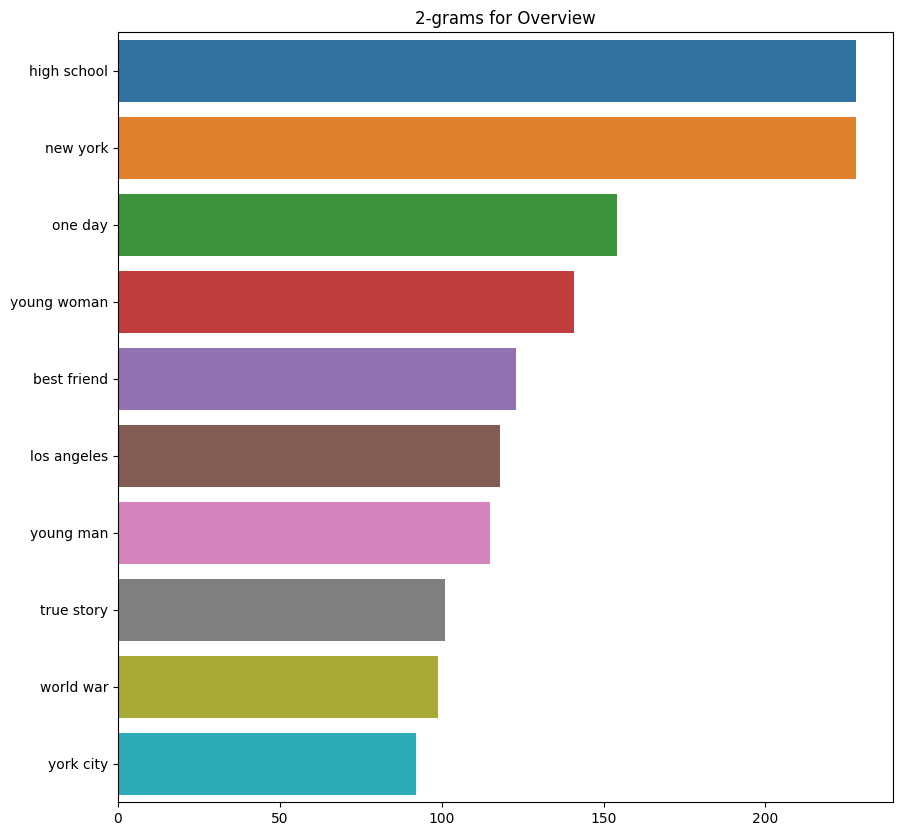

In [75]:
def plot_top_ngrams_barchart(text, column, n=2):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    plt.title(f'{n}-grams for {column}')

#2-grams for overview
plot_top_ngrams_barchart(data['Overview'],'Overview', 2)

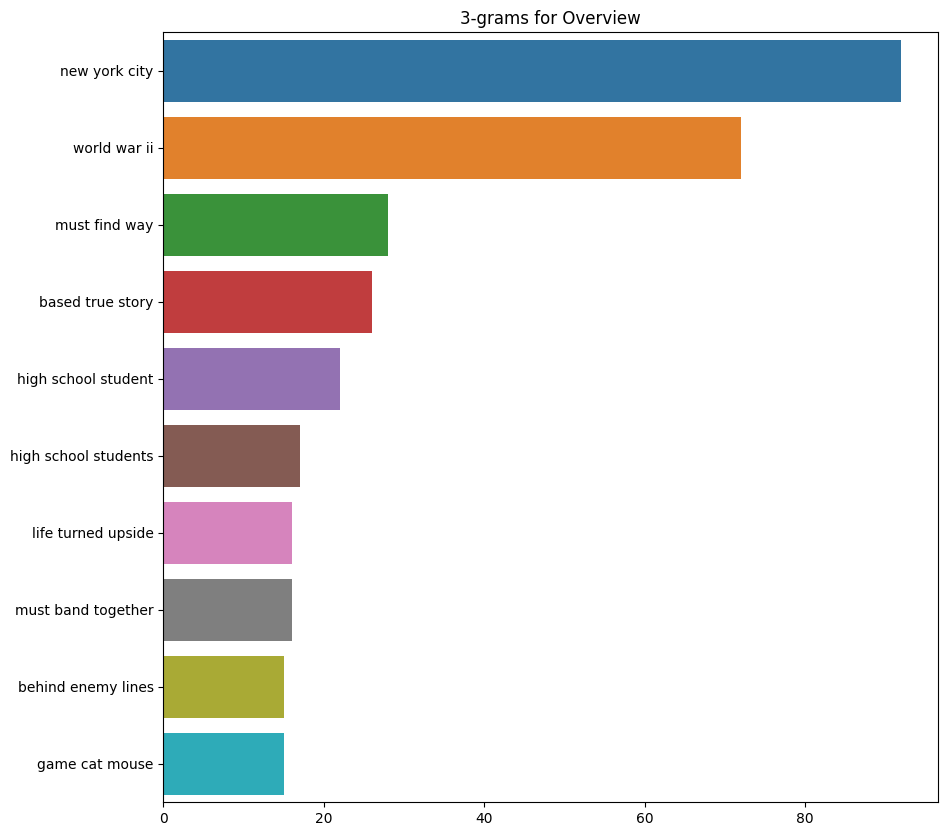

In [76]:
# 3 grams for Overview
plot_top_ngrams_barchart(data['Overview'],'Overview', 3)

- The top 2-gram found the the Overview column was high school followed by new york.
- The top 3-gram found in overview were new york city, followed by word war ii

## Numerical Data Visualizations

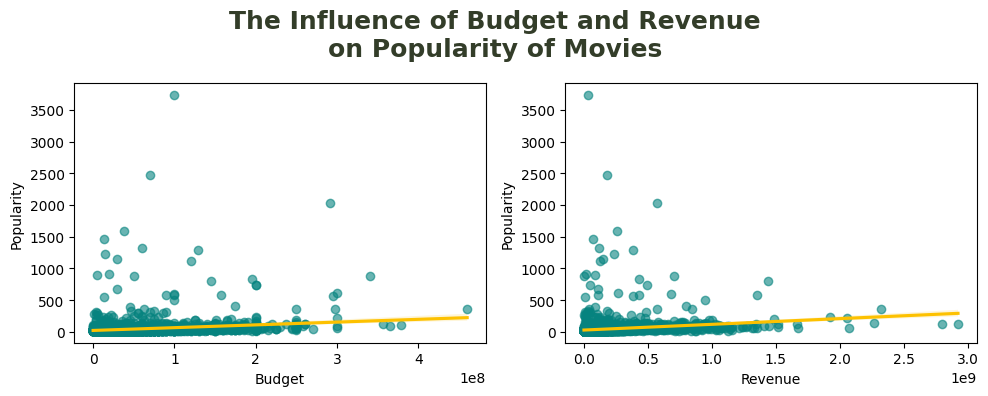

In [78]:
# The influence of budget and revenue in popularity

df_plot = data[(data['Budget'] != 0) & (data['Revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['Budget', 'Revenue']):
    sns.regplot(data=df_plot, x=col, y='Popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

Note: It seems there may be a positive correlation between Budget and Popularity.

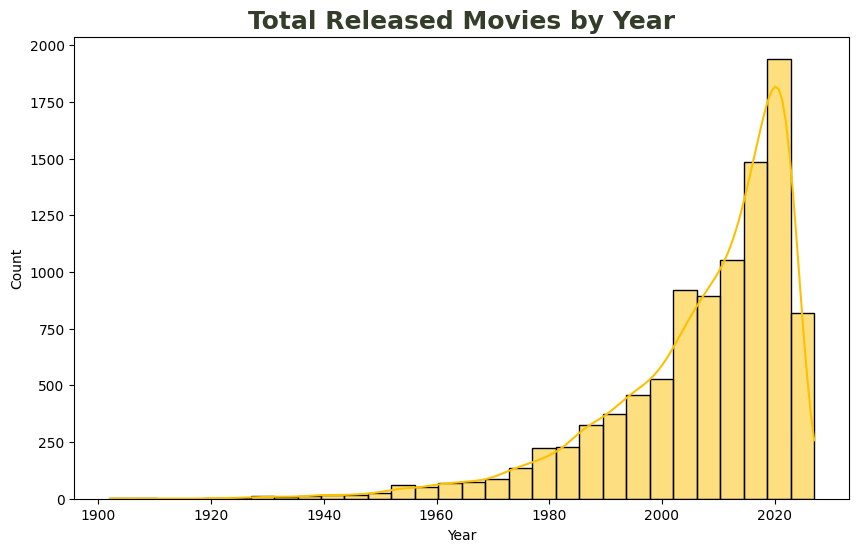

In [80]:
# Reviewing the total released movies by year

data['ReleaseDate'] = pd.to_datetime(data['ReleaseDate'])

# Extract the year from the 'ReleaseDate' column
data['Year'] = data['ReleaseDate'].dt.year

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Year', kde=True, color='#fdc100', bins=30)
plt.title('Total Released Movies by Year', fontsize=18, weight=600, color='#333d29')
plt.show()

Note: The total releases is higher for more recent years.

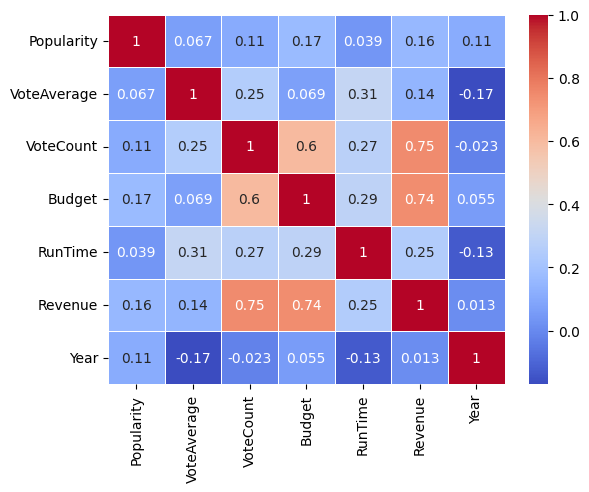

In [111]:
# Reviewing correlations between numerical columns

numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 'Year']

df_numericals = data[numerical_columns]

correlation_matrix = df_numericals.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


Note:

The above graph shows a potential correlation between Budget, VoteCount with Revenue.

Numerical data distributions will be analyzed in the Step 6 and 7 during outliers analysis.

# Step 4

## Pandas Profiling

In [84]:
if create_pandas_profiling:
    profile = ProfileReport(data, title="Profiling Report")
    profile.to_file("Report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 108.25it/s]


Notes:

The profiling report helps us to conclude the following:

- VoteCount is highly overall correlated with Budget and Revenue. Additionally, Budget and Revenue have a vast presence of zeros, 42% and 37%, respectively. Therefore, we decided to move forward with VoteCount and remove the other mentioned columns.
- We could see a high imbalance for the production continents. Additionally, high correlation with OriginalLanguage for some of the continents as Asia and North America. Therefore, we decided to remove for modeling the production continents and keep the OriginalLanguage column.




# Step 5

In [83]:
# Function to perform numerical features scaling
def get_scaled_features(data, numerical_features):
    X_numerical = data[numerical_features].values
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X_numerical)
    return X_numerical_scaled

# Step 6

 ##  Outliers Identification

In [86]:
# Indentifing the numerical columns in the clean dataset
data.select_dtypes(include=['int', 'float']).columns

Index(['OriginalLanguage', 'Popularity', 'VoteAverage', 'VoteCount', 'Budget',
       'RunTime', 'Revenue', 'North America', 'Europe', 'Asia', 'Oceania',
       'South America', 'Africa', 'Year'],
      dtype='object')

In [87]:
# Filtering out the discrete numerical columns (those are categorical that were enconded in previous steps)
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']
numerical_df = data[numerical_columns]

In [88]:
numerical_df.describe()

,Popularity,VoteAverage,VoteCount,Budget,RunTime,Revenue
count,9821.000000,9821.000000,9821.000000,9.821000e+03,9821.000000,9.821000e+03
mean,34.389345,6.419010,1632.730883,2.068280e+07,102.605743,6.288832e+07
std,85.031911,1.266108,2960.658943,3.896529e+07,26.178903,1.569095e+08
min,13.049000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,15.583000,6.000000,176.000000,0.000000e+00,91.000000,0.000000e+00
50%,20.092000,6.600000,573.000000,2.500000e+06,101.000000,4.100000e+06
75%,30.488000,7.200000,1681.000000,2.500000e+07,115.000000,5.518113e+07
max,3741.062000,10.000000,34628.000000,4.600000e+08,400.000000,2.923706e+09


### Boxplots

In [89]:
# Function to create boxplot to see percetiles and outliers presence

def create_box_plot(column, title, r1, r2):
    q3 = np.percentile(column, 75)
    q1 = np.percentile(column, 25)
    IQR = q3 - q1
    upper_fence = q3 + IQR * 1.5
    lower_fence = q1 - IQR * 1.5

    fig = plt.figure(1, figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title + " Boxplot")

    r1 = min(r1, lower_fence)
    r2 = max(r2, upper_fence)

    ax.boxplot(column , vert=False, manage_ticks=True)
    ax.set_xlabel('values')
    ax.set_yticks([1])
    ax.set_yticklabels([title])

    quantiles = np.quantile(column , np.array([0.00, 0.25, 0.50, 0.75]))
    quantiles = np.append(quantiles, upper_fence)
    quantiles = np.insert(quantiles, 0, lower_fence)
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
              color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    plt.xlim(r1, r2)
    ax.tick_params(axis='x', labelsize=8)
    plt.show()

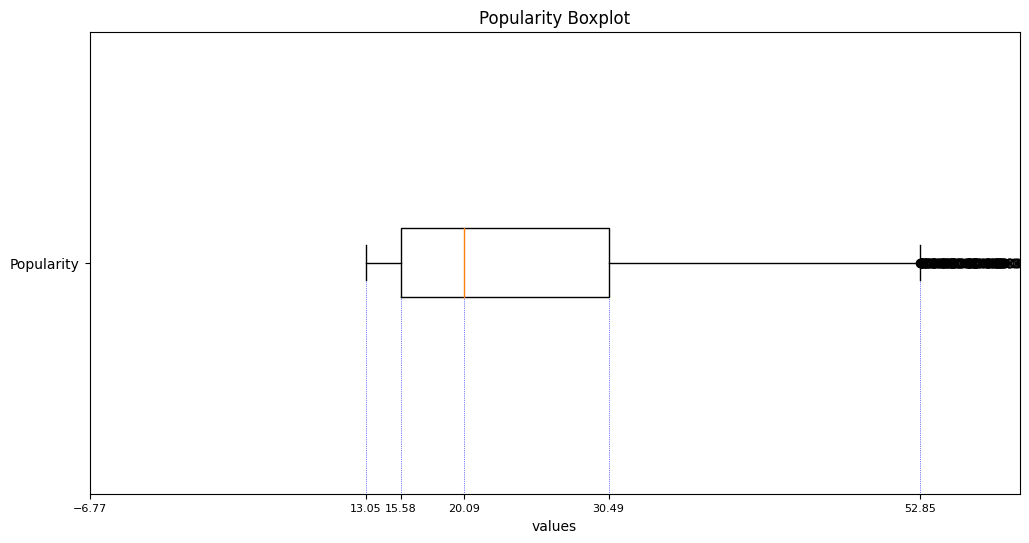

In [90]:
# Popularity Boxplot
create_box_plot(data['Popularity'], 'Popularity', 0, 60)

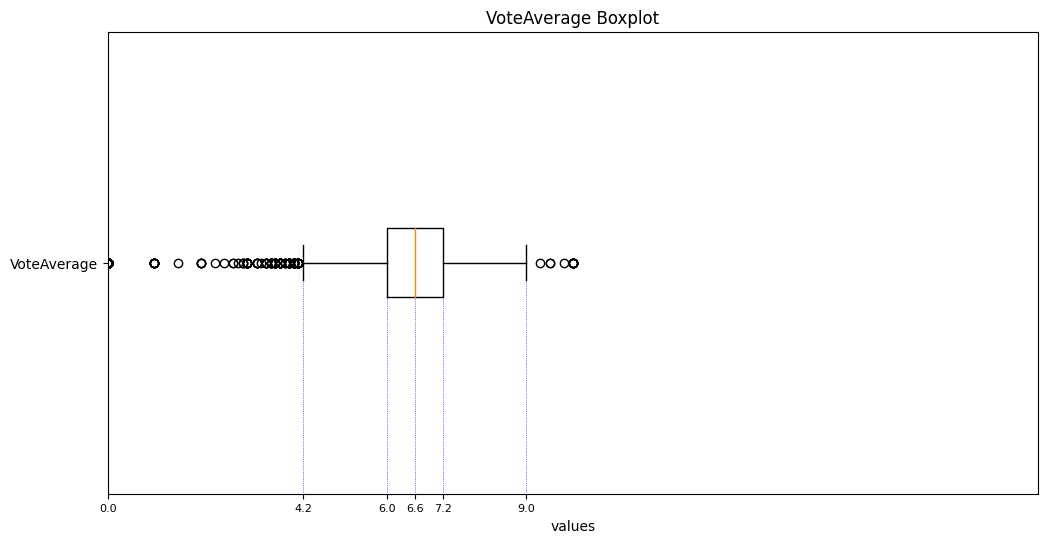

In [91]:
# VoteAverage Boxplot
create_box_plot(data['VoteAverage'], 'VoteAverage', 0, 20)

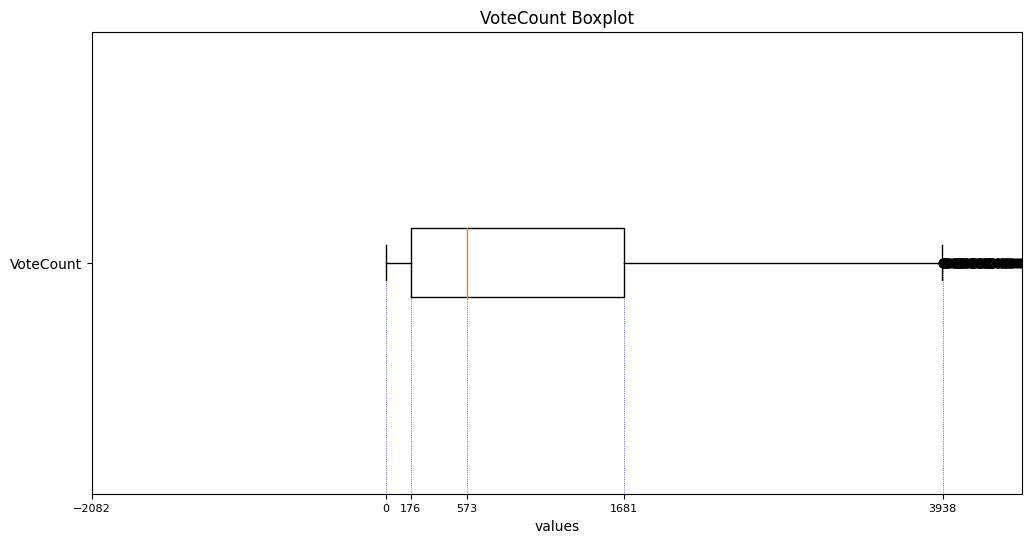

In [92]:
# VoteCount Boxplot
create_box_plot(data['VoteCount'], 'VoteCount', 0, 4500)

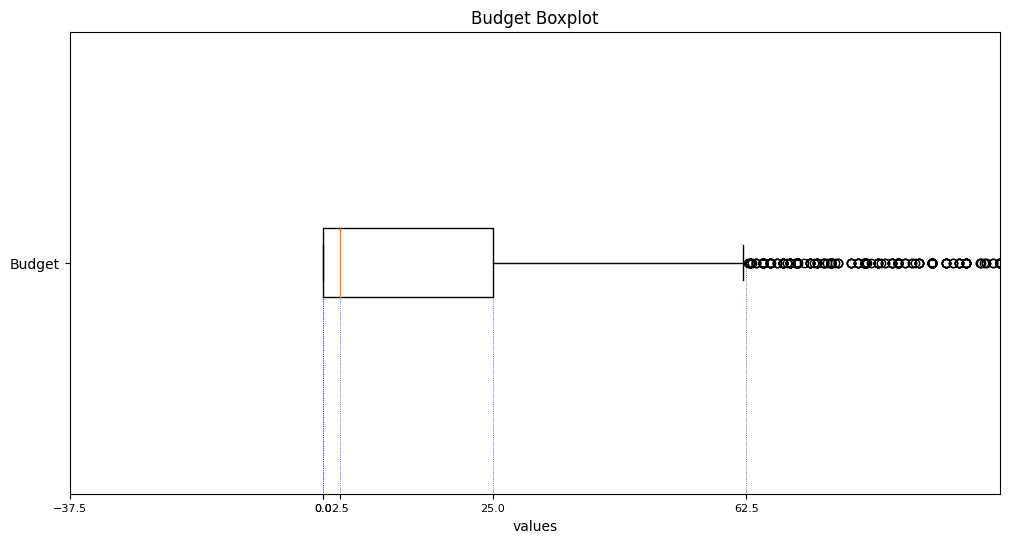

In [93]:
# Scaled Budget Boxplot
create_box_plot((data['Budget']) / 1000000, 'Budget', 0, 100)

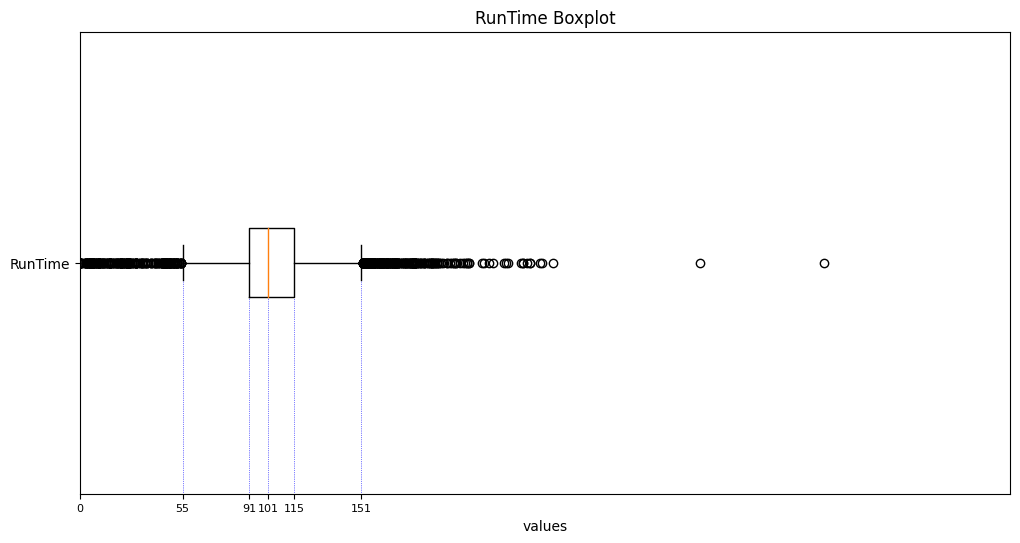

In [94]:
# RunTime Boxplot
create_box_plot(data['RunTime'], 'RunTime', 0, 500)

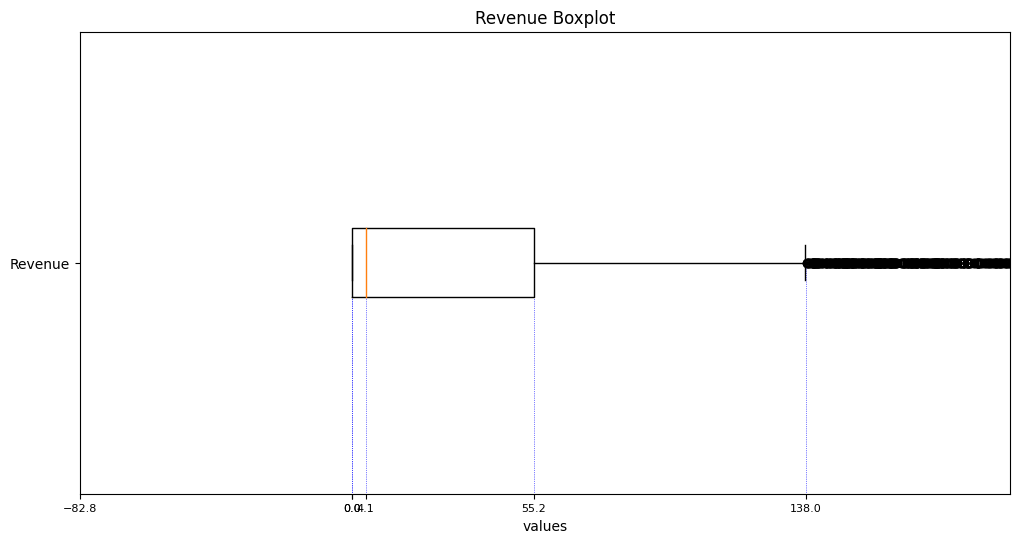

In [95]:
# Scaled Revenue Boxplot
create_box_plot((data['Revenue'] / 1000000), 'Revenue', 0, 200)

Notes:

The function "create_box_plot" was created to inspect the outliers in the columns visually:

1. The function accepts three arguments; "column" which is the data for the boxplot, "title" which impacts the title and label we want to add to the boxplot. And (r1,r2), which is the range of data we want to plot.
2. It calculates the percentiles q3, q1, and the IQR to compute the upper and lower fences to be included in the boxplot.
3. The quantiles  [0, 25, 50, 75] are calculated and stored in an array called "quantiles". The array is modified with the lower fence at position 0 and the upper fence at the last position.
4. The quantiles array is passed to the method, .vlines which handles the vertical lines
5. The quantiles array is also passed to the .set_xticks to see the numbers in the x-axis in the boxplot
6. Finally, the range in X to plot is established using the method .xlim

The plots show:

1. Popularity: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 15.59, 50% of the data fall below 20.1, 75% of the data fall below 30.33. The upper extreme is at 52, and the lower extreme is at 13.05.

2. VoteAverage: This shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 6.00, 50% of the data fall below 6.60, 75% of the data fall below 7.10. The upper extreme is at 8.75, and the lower extreme is at 4.35.

3. VoteCount: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 170, 50% of the data fall below 564, and 75% of the data fall below 1668. The upper extreme is at 3915, and the lower extreme is at 0.

4. Budget: The budget was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 2.2M, and 75% of the data fall below 25M. The upper extreme is at 62.5M, and the lower extreme is at 0.

5. RunTime: Shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 91 min, 50% of the data fall below 101 min, and 75% of the data fall below 115 min. The upper extreme is at 151 min, and the lower extreme is at 55 min.

6. Revenue: Revenue was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 8.8 M, and 75% of the data fall below 54.6 M. The upper extreme is at 136.5 M, and the lower extreme is at 0.




# Step 7

## Outliers Handling

### Method 1: Quantile-based Flooring and Capping

In [97]:
# Function to apply flooring and capping method for outlier handling

def apply_flooring_capping(data, floor, cap):
    floor_q = data.quantile(0.01)
    cap_q = data.quantile(0.99)
    result = data.copy()
    result = np.where(result < floor_q, floor_q, result)
    result = np.where(result > cap_q, cap_q, result)
    return result


In [98]:
# Function to plot two boxplot
def create_boxplots(arr1, arr2, r1, r2, label1, label2):
    ax = sns.boxplot(data=[arr1, arr2], orient='h')
    plt.xlim(r1, r2)
    ax.set_yticklabels([label1, label2])

In [99]:
# Applying quantile-based flooring and capping to Popularity

popularity_fc = apply_flooring_capping(data['Popularity'], 0.01, 0.99)

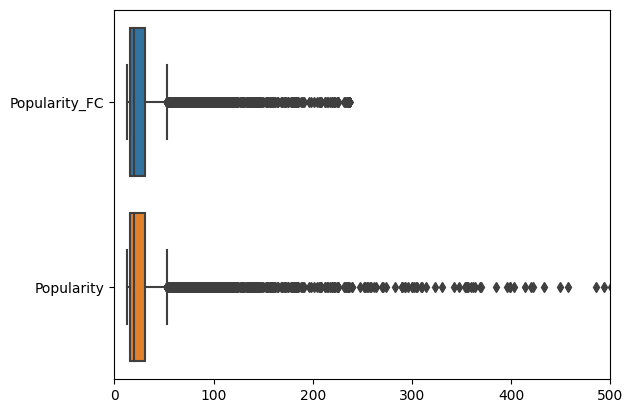

In [100]:
# Boxplots to compate Popularity with and without quantile-based flooring and capping
create_boxplots(popularity_fc, data['Popularity'], 0, 500, 'Popularity_FC', 'Popularity')

In [101]:
# Applying quantile-based flooring and capping to VoteAverage

vote_average_fc = apply_flooring_capping(data['VoteAverage'], 0.01, 0.99)

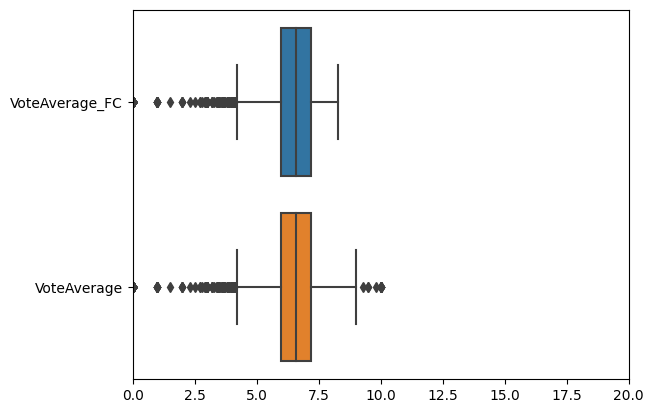

In [102]:
# Boxplots to compate VoteAverage with and without quantile-based flooring and capping
create_boxplots(vote_average_fc, data['VoteAverage'], 0, 20, 'VoteAverage_FC', 'VoteAverage')

In [103]:
# Applying quantile-based flooring and capping to VoteCount

vote_count_fc = apply_flooring_capping(data['VoteCount'], 0.01, 0.99)

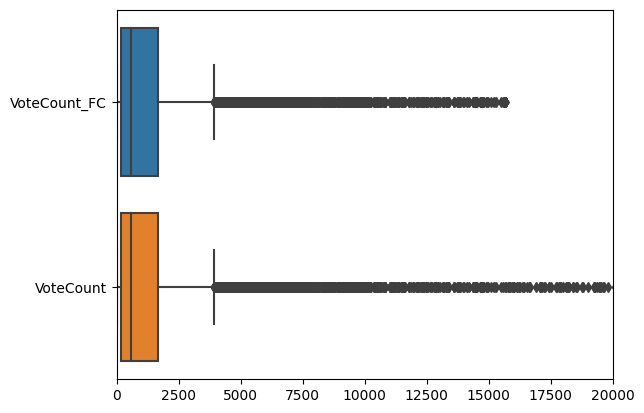

In [104]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(vote_count_fc, data['VoteCount'], 0, 20000, 'VoteCount_FC', 'VoteCount')

In [105]:
# Applying quantile-based flooring and capping to Budget

budget_fc = apply_flooring_capping(data['Budget'], 0.01, 0.99)

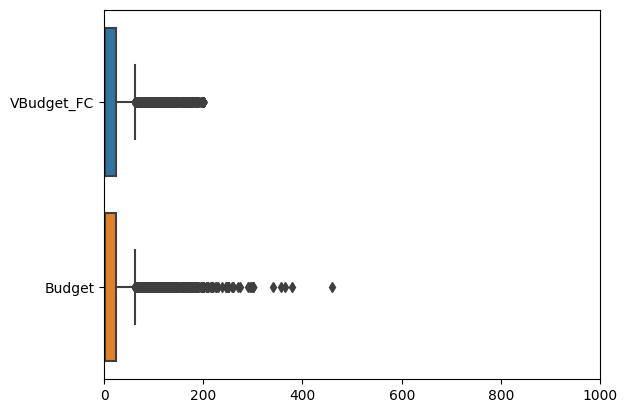

In [106]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(budget_fc / 1000000, data['Budget'] / 1000000, 0, 1000, 'VBudget_FC', 'Budget')

In [107]:
# Applying quantile-based flooring and capping to RunTime

runtime_fc = apply_flooring_capping(data['RunTime'], 0.01, 0.99)

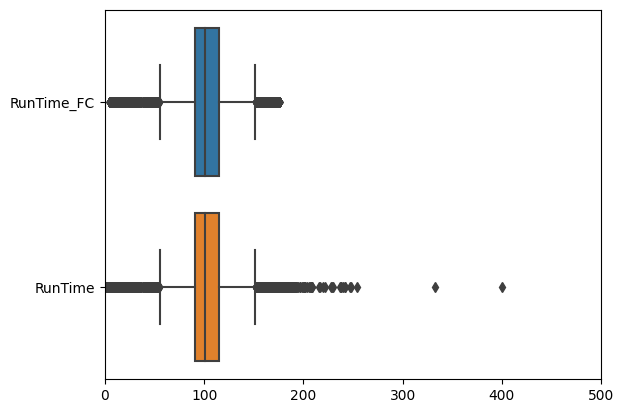

In [108]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(runtime_fc, data['RunTime'], 0, 500, 'RunTime_FC', 'RunTime')

In [109]:
# Applying quantile-based flooring and capping to Revenue

revenue_fc = apply_flooring_capping(data['Revenue'], 0.01, 0.99)

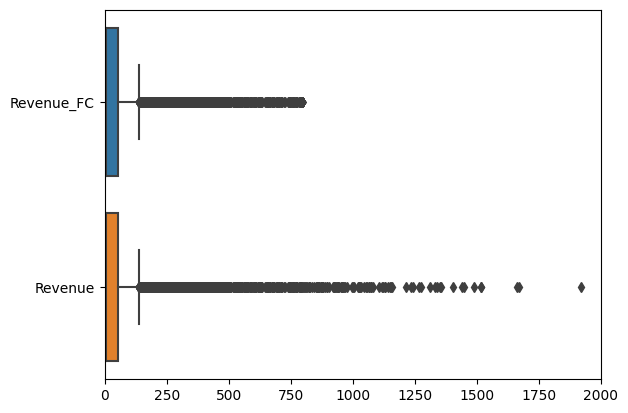

In [110]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(revenue_fc / 1000000, data['Revenue'] / 1000000, 0, 2000, 'Revenue_FC', 'Revenue')

### Method 2: Trimming

In [112]:
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']

In [113]:
# method to return a copy of a data frame after trimming the numerical valiables
def get_trimmed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        upper_q = np.quantile(data[col], 0.75)
        lower_q = np.quantile(data[col], 0.25)
        IQR = upper_q - lower_q
        upper_whisker = upper_q + (1.5 * IQR)
        lower_whisker = lower_q - (1.5 * IQR)
        indexes = result[(result[col] > upper_whisker) | (result[col] < lower_whisker)].index
        print(f'Droping {indexes.shape[0]} indexes for {col}')
        result.drop(indexes, inplace=True)
        print(f'Data final shape {result.shape}')
    return result


In [114]:
# getting trimmed new data
trimmed_data = get_trimmed_data(data, numerical_columns)

Droping 1015 indexes for Popularity
Data final shape (8806, 19)
Droping 299 indexes for VoteAverage
Data final shape (8507, 19)
Droping 653 indexes for VoteCount
Data final shape (7854, 19)
Droping 390 indexes for Budget
Data final shape (7464, 19)
Droping 408 indexes for RunTime
Data final shape (7056, 19)
Droping 256 indexes for Revenue
Data final shape (6800, 19)


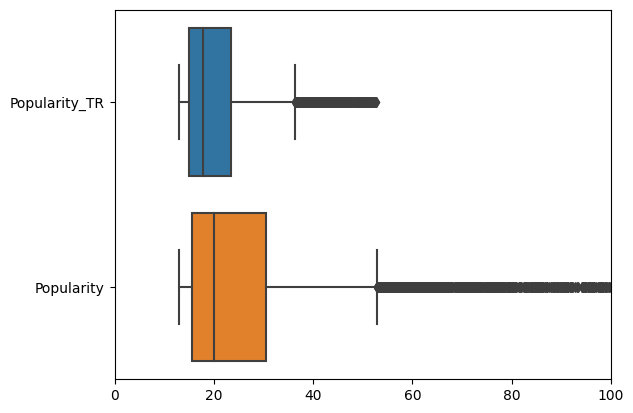

In [115]:
# Boxplots to compare trimmed and no-trimmed Popularity
create_boxplots(trimmed_data['Popularity'], data['Popularity'], 0, 100, 'Popularity_TR', 'Popularity')

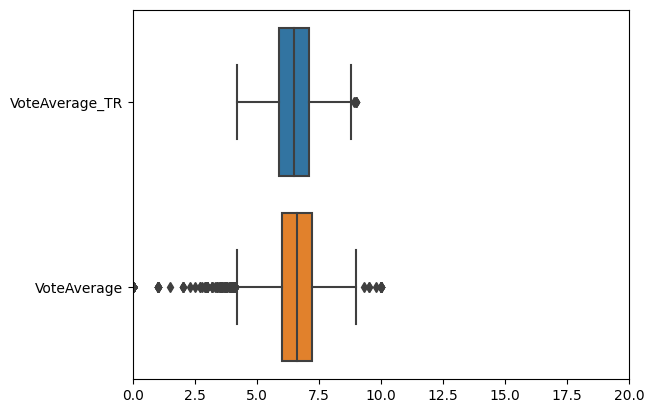

In [116]:
# Boxplots to compare trimmed and no-trimmed 'VoteAverage'
create_boxplots(trimmed_data['VoteAverage'], data['VoteAverage'], 0, 20, 'VoteAverage_TR', 'VoteAverage')

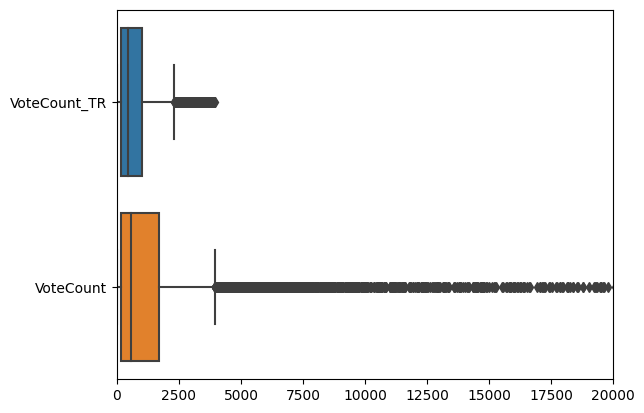

In [117]:
# Boxplots to compare trimmed and no-trimmed VoteCount
create_boxplots(trimmed_data['VoteCount'], data['VoteCount'], 0, 20000, 'VoteCount_TR', 'VoteCount')

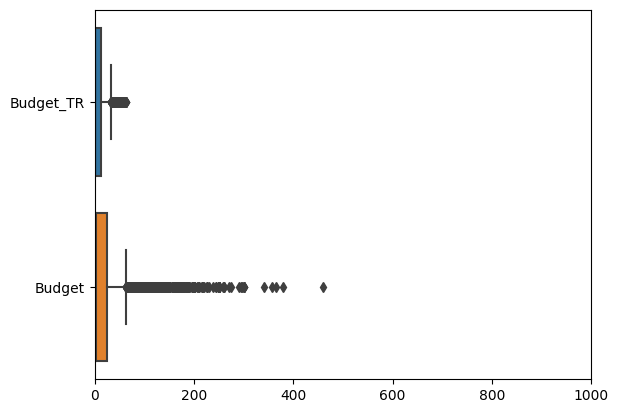

In [118]:
# Boxplots to compare trimmed and no-trimmed Budget
create_boxplots(trimmed_data['Budget'] / 1000000, data['Budget'] / 1000000, 0, 1000, 'Budget_TR', 'Budget')

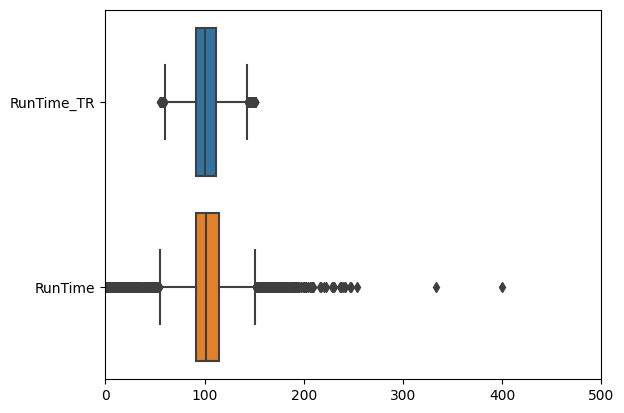

In [119]:
# Boxplots to compare trimmed and no-trimmed RunTime
create_boxplots(trimmed_data['RunTime'], data['RunTime'], 0, 500, 'RunTime_TR', 'RunTime')

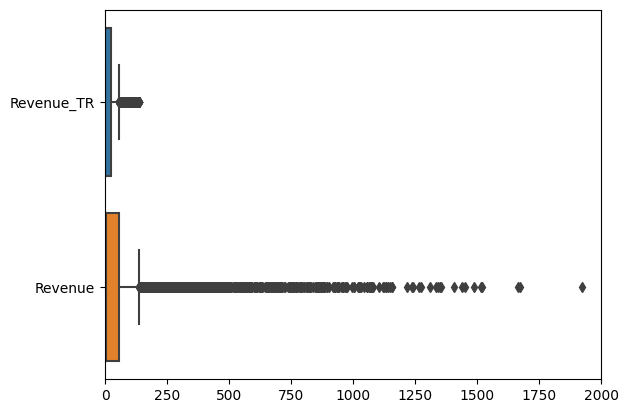

In [120]:
# Boxplots to compare trimmed and no-trimmed Revenue
create_boxplots(trimmed_data['Revenue'] / 1000000, data['Revenue']/1000000, 0, 2000, 'Revenue_TR', 'Revenue')

### Method 3: Log Transformation

In [121]:
# Function to apply log tranformation to data, returns a copy with transformed columns
def get_log_transformed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        result[col] = result[col].map(lambda x: np.log(x) if x > 0 else 0)
    return result


In [122]:
# create graph to compare boxplots
def pair_boxplots(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].boxplot(arr1, vert=False)
    axes[0].set_title(f'Boxplot {label1}')
    axes[1].boxplot(arr2, vert=False)
    axes[1].set_title(f'Boxplot {label2}')
    plt.show()

# create graph to compare histograms
def pair_histograms(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(arr1, bins=20)
    axes[0].set_title(f'Histogram {label1}')
    axes[1].hist(arr2, bins=20)
    axes[1].set_title(f'Histogram {label2}')
    plt.show()


In [123]:
# Understanding skewness correction for Popularity
log_transformed_data = get_log_transformed_data(data, numerical_columns)
skewness_td = log_transformed_data['Popularity'].skew().round(2)
skewness_d = data['Popularity'].skew().round(2)
print(f'Skewness transformed data {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data 2.13
Skewness data: 20.03


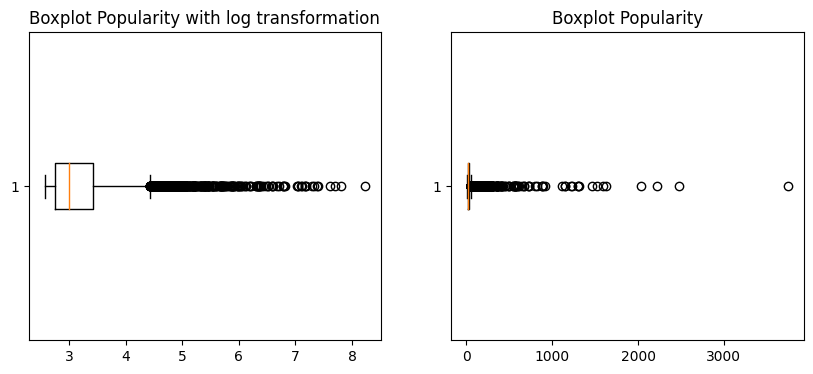

In [124]:
# boxplots for Popularity with and without log transformation
pair_boxplots(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

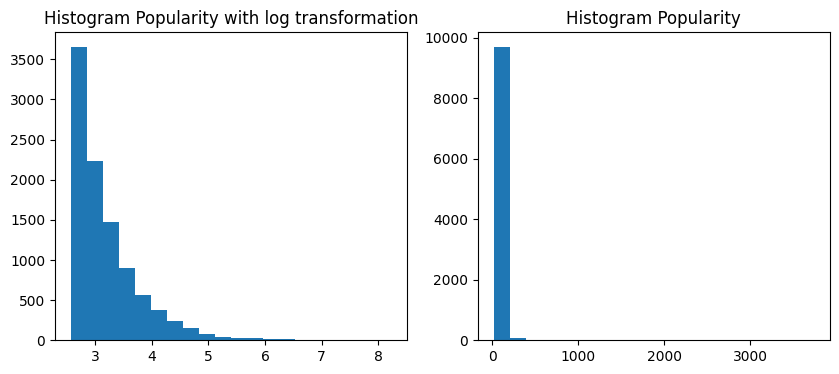

In [125]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

In [126]:
# Understanding skewness correction for VoteAverage
skewness_td = log_transformed_data['VoteAverage'].skew().round(2)
skewness_d = data['VoteAverage'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -4.65
Skewness data: -2.54


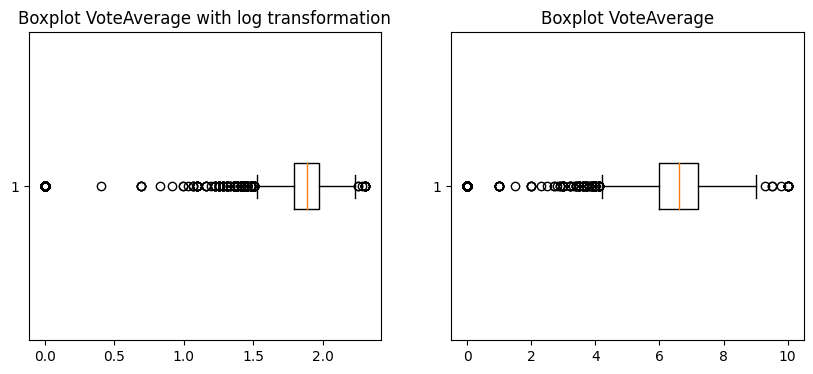

In [127]:
# boxplots for VoteAverage with and without log transformation
pair_boxplots(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

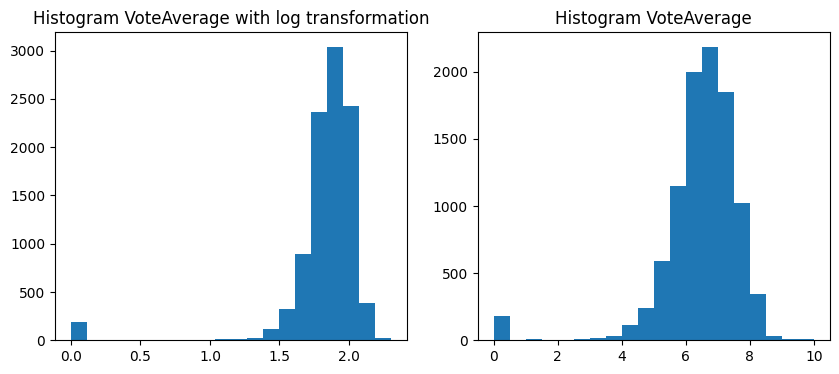

In [128]:
# histograms for VoteAverage with and without log transformation
pair_histograms(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

In [129]:
# Understanding skewness correction for VoteCount
skewness_td = log_transformed_data['VoteCount'].skew().round(2)
skewness_d = data['VoteCount'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.95
Skewness data: 4.04


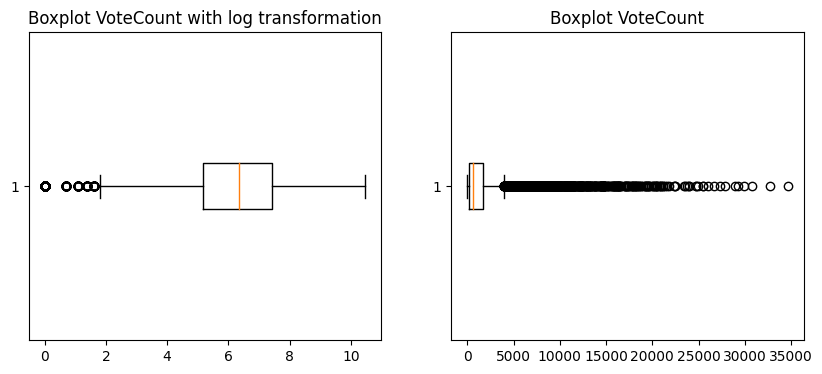

In [130]:
# boxplots for VoteCount with and without log transformation
pair_boxplots(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

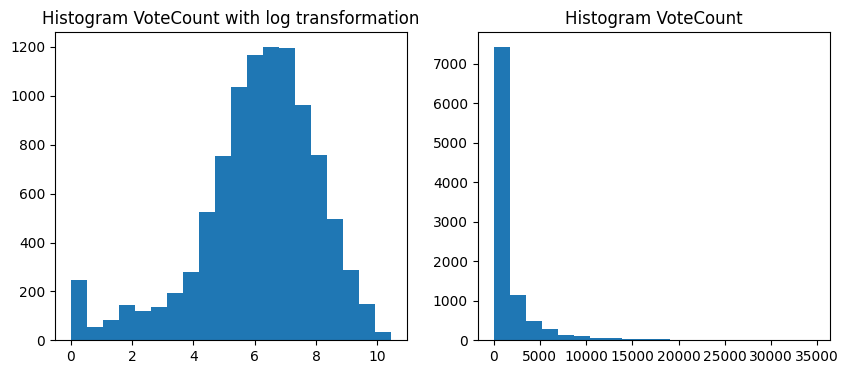

In [131]:
# histograms for VoteCount with and without log transformation
pair_histograms(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

In [132]:
#Understanding skewness correction for Budget
skewness_td = log_transformed_data['Budget'].skew().round(2)
skewness_d = data['Budget'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.18
Skewness data: 3.22


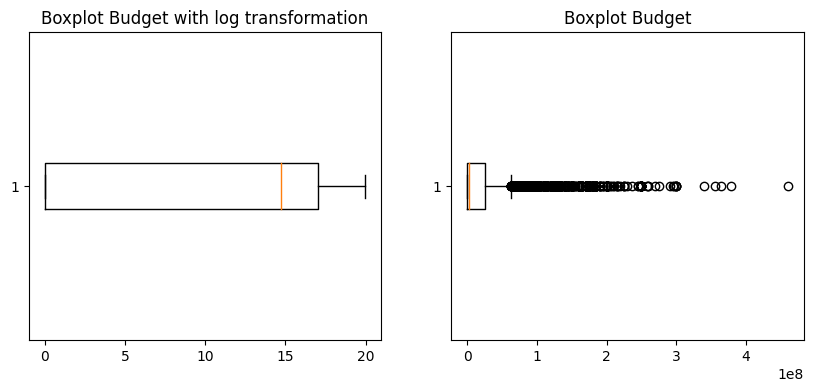

In [133]:
# boxplots for Budget with and without log transformation
pair_boxplots(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

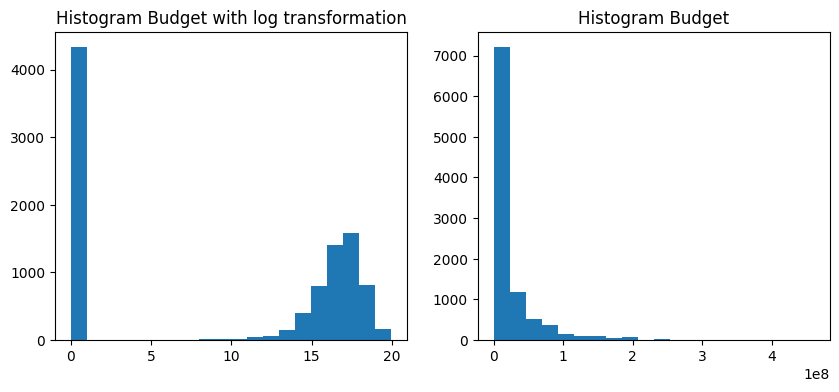

In [134]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

In [135]:
# Understanding skewness correction for RunTime
skewness_td = log_transformed_data['RunTime'].skew().round(2)
skewness_d = data['RunTime'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -6.04
Skewness data: -0.18


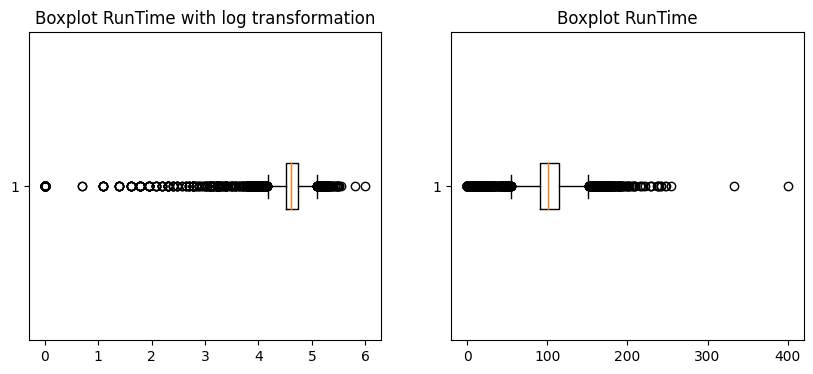

In [136]:
# boxplots for RunTime with and without log transformation
pair_boxplots(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

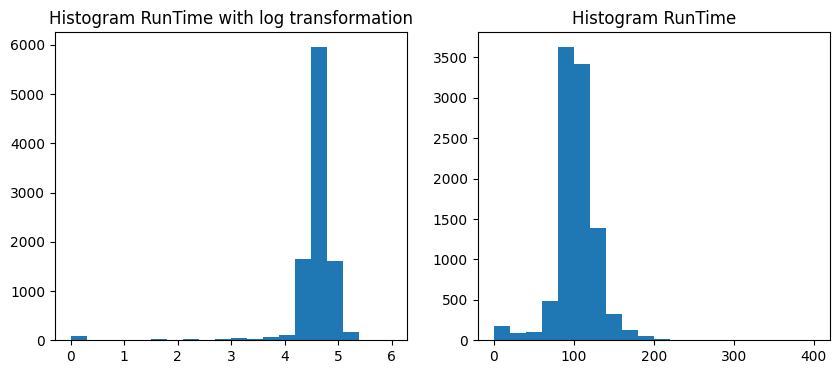

In [137]:
# histograms for RunTime with and without log transformation
pair_histograms(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

In [138]:
# Understanding skewness correction for Revenue
skewness_td = log_transformed_data['Revenue'].skew().round(2)
skewness_d = data['Revenue'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.27
Skewness data: 5.89


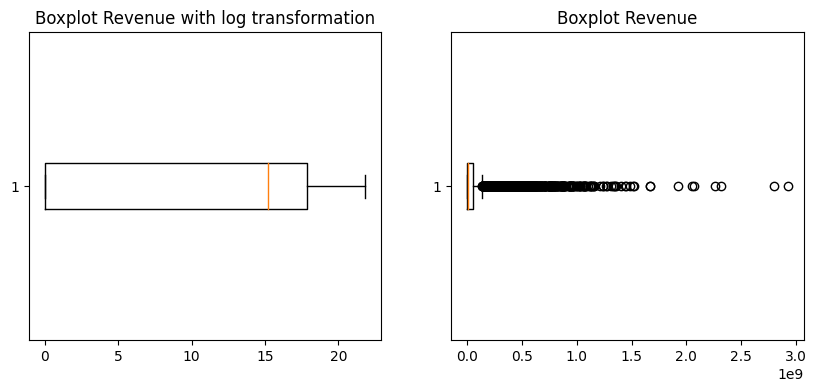

In [139]:
# boxplots for Revenue with and without log transformation
pair_boxplots(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

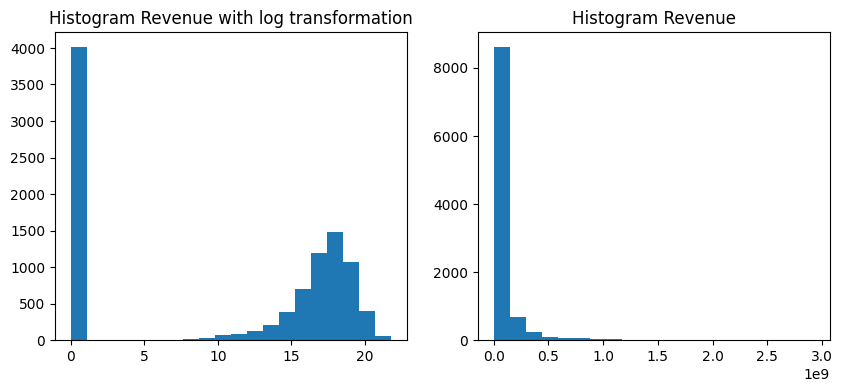

In [140]:
# histograms for Revenue with and without log transformation
pair_histograms(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

In [141]:
# applying Trimming to log transformed Popularity
logt_trimmed_data = get_trimmed_data(log_transformed_data, ['Popularity'])

Droping 466 indexes for Popularity
Data final shape (9355, 19)


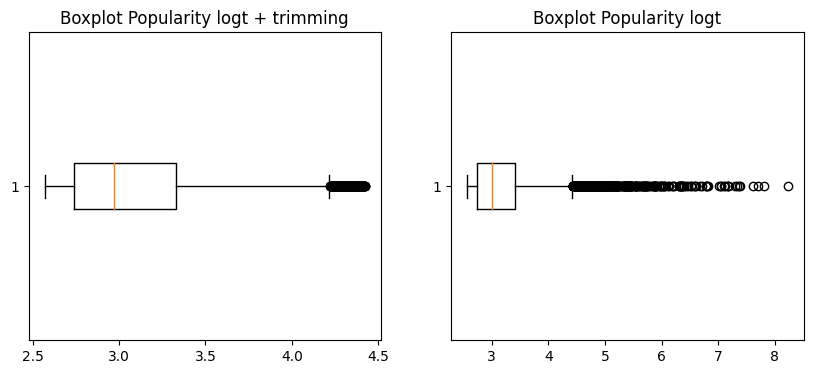

In [142]:
# final Popularity log transformation + trimming

pair_boxplots(logt_trimmed_data['Popularity'], log_transformed_data['Popularity'], 'Popularity logt + trimming', 'Popularity logt')

### Final dataset without outliers

The following transformations are done best on the strategy that worked best for an specific distribution

In [143]:
# final dataset without outliers

# 1 Trimming columns 'VoteAverage' and 'RunTime'
movies_data_trimmed = get_trimmed_data(data, ['VoteAverage', 'RunTime'])

# Log tranformation for 'Budget', 'Revenue', 'VoteCount' and 'Popularity'
movies_data_log_transform = get_log_transformed_data(movies_data_trimmed, ['Budget', 'Revenue', 'VoteCount', 'Popularity'])

# Apply trimming to the log tranformed 'Popularity'

movies_data = get_trimmed_data(movies_data_log_transform, ['Popularity'])


Droping 318 indexes for VoteAverage
Data final shape (9503, 19)
Droping 546 indexes for RunTime
Data final shape (8957, 19)
Droping 418 indexes for Popularity
Data final shape (8539, 19)


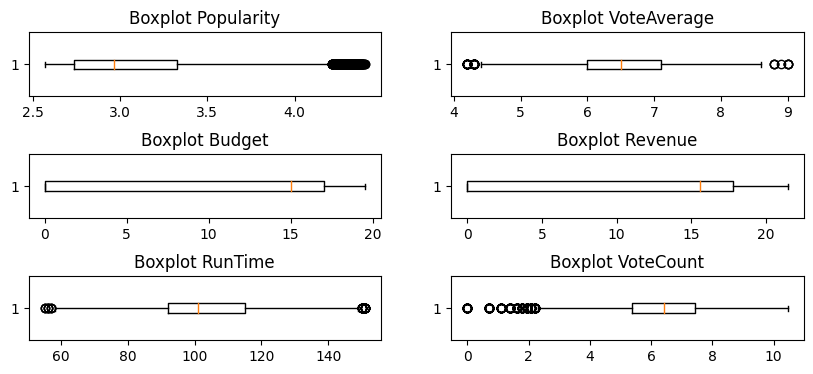

In [144]:
# boxplot to final confirm all distributions

fig, axes = plt.subplots(3, 2, figsize=(10, 4))
plt.subplots_adjust(hspace=0.9)
axes[0][0].boxplot(movies_data['Popularity'], vert=False)
axes[0][0].set_title('Boxplot Popularity')
axes[0][1].boxplot(movies_data['VoteAverage'], vert=False)
axes[0][1].set_title('Boxplot VoteAverage')
axes[1][0].boxplot(movies_data['Budget'], vert=False)
axes[1][0].set_title('Boxplot Budget')
axes[1][1].boxplot(movies_data['Revenue'], vert=False)
axes[1][1].set_title('Boxplot Revenue')
axes[2][0].boxplot(movies_data['RunTime'], vert=False)
axes[2][0].set_title('Boxplot RunTime')
axes[2][1].boxplot(movies_data['VoteCount'], vert=False)
axes[2][1].set_title('Boxplot VoteCount')
plt.show()


In [145]:
# storing the final dataset with outliers handling as movies_data.csv
movies_data.to_csv('movies_data.csv')

Notes:

Quantile-based Flooring and Capping:

- Overall, it showed an improvement in skewness. However, for all the columns, we still got a significant presence of outliers.

Trimming:

- This method is not an option as a unique method to fix outliers due to a significant data loss. After trimming, the number of rows was reduced from 9979 to just 6796 (32%). Additionally, in terms of improving outliers, although it reduced the skewness for some columns, it was more effective for 'VoteAverage' and 'RunTime' (both have the most symmetric distributions). The other columns still have a significant presence of outliers.
    
Log Transformation

- This method presents a small change for those columns that already have a symmetrical distribution, such as RunTime and VoteAverage. On the other hand, for those skewed distributions, this method allowed a more symmetrical one, as seen in Popularity, VoteCount, Budget, and Revenue.

- This transformation successfully removed outliers for 'Budget', 'Revenue' and 'VoteCount'. Additionally, it improved the distributions for Popularity and VoteCount.

Considering the results applying each of the methods for all the columns, we decided to remove the outliers as follows:

- 'VoteAverage' and 'RunTime' -> Trimming
- 'Budget', 'Revenue' and VoteCount-> Log Tranformation
- 'Popularity' -> Log Tranformation + Trimming

Using above strategy, we were able to remove ourliers and improve skewness for the columns.

Finally, we stored the dataset as movies_data.csv





# Step 8

## Unsupervised Learning

We decided two used two methods:

- Latent Dirichlet Allocation, Topic modeling for textual data
- K-means clustering

In [147]:
# retrieving the data that contain all the transformations
data = pd.read_csv('movies_data.csv', lineterminator='\n', index_col='Id')
# read_csv parse empty strings as nulls, the following line correct this
data['TagLine'].fillna('', inplace=True)

In [148]:
text_columns = ['Overview', 'Genres', 'TagLine']
# Feature engineering a new text column as the sum of other text columns
data['joined_text'] = data[text_columns].apply(lambda x: ' '.join(x), axis=1)

### Topic Modeling LDA (Latent Dirichlet Allocation)

In [152]:
def get_tfidf_lda_objects(text):
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w) > 2]

            corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_vectorizer.fit_transform([" ".join(doc) for doc in corpus])

    dic = corpora.Dictionary(corpus)
    tfidf_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model = models.LdaMulticore(tfidf_corpus,
                                   num_topics=10,
                                   id2word=dic,
                                   passes=10,
                                   workers=2)

    return lda_model, tfidf_corpus, dic

def plot_tfidf_lda_vis(lda_model, tfidf_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, tfidf_corpus, dic, mds='tsne', R=15)
    return vis

if run_lda_training:
    lda_model, tfidf_corpus, dic  = get_tfidf_lda_objects(data['Overview'])
    lda_model.show_topics()

    vis = plot_tfidf_lda_vis(lda_model, tfidf_corpus, dic)

    # Save the visualization as an HTML file
    pyLDAvis.save_html(vis, 'lda_visualization_overview.html')


In [153]:
# To display the saved file in the notebook
display(HTML('lda_visualization_overview.html'))

Notes:

We used Latent Dirichlet Allocation, a model used for topic modeling in NLP. This particular model helps us discover the abstract "topics" in the documents. To train the LDA model, we defined the number of topics as 10. Additionally, we used the TfidfVectorizer as a vectorizer; we specified as 10 the number of passes through the corpus. Finally, we set the number of threads for paralization (workers) as 2.

Additionally, to read the visualizations, we had to select the relevancy metric to use (lambda at the top right slider)

- lambda = 1, Sorts the words based on the frequency in the topic.
- lambda = 0, Ranks the words based on their uniqueness.
- Selection: As we want to understand the differences between the topics, we want to balance those unique words with more general words. Therefore,  we selected lambda = 0.5 and reduced it to lambda=0 for some cases.

We created the topics for the Overview to represent the movie's content.

Based on the dynamic visualizations built for the topics and the different lambda configurations, we can conclude:

1. The topics are not close or interconnected. Furthermore, Topic 1 has the biggest circle, which means there are more words associated with this topic compared to other topics. However, the circle size between the other topics is similar.

2. Topics:
    - topic 1: With lambda=0, we see words that can be used mostly in scary movies, such as ash, evil, dimension (other dimensions?), and treacherous.
    - topic 2: We can see terms that lead us to consider this topic related to drama, words like planet, brother, and angeles.
    topic 3: We could see words like monster, mysterious, ruby, russian, human, father, quentin. This topic seems related to action-drama type of movies.
    - topic 4: This topic resembles war, with words such as war, jung, royal, american, border, halt, cartel, and stitch.
    - topic 5: Seem related to drama in the context of sports, with words such as football, roman, prison, mark, campus, killer.
    - topic 6: This topic is about teenage dramas, with words such as teacher, school, popular, one, gym, and meet.
    - topic 7: This category covers drama in a family context, with words such as family, grace, finding, parent, detective, neighbor, and country.
    - topic 8: This topic seems to cover teenage drama in a science fiction context with words such as school, high, tunnel, station, robot, drug, and ship.
    - topic 9: with words such as vill, take, and christmas, this topic may be related to Christmas movies.
    - topic 10: This topic is related to policy and crime, with words such as agent, gang, driver, thief, robbery, and police.







### Clustering K-means

In [155]:
# Feature Engineering 'weighted_average'
R = data['VoteAverage']
v = data['VoteCount']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = data['VoteCount'].quantile(0.8)
C = data['VoteAverage'].mean()

data['weighted_average'] = (R*v + C*m)/(v+m)

In [156]:
# Selected columns based on previous feaure analysis
data['ReleaseDate'] = pd.to_datetime(data['ReleaseDate'])
data['Year'] = data['ReleaseDate'].dt.year
text_columns = ['Overview', 'Genres', 'TagLine']

In [157]:
# Textual data vectorizing

joined_text = data['joined_text'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(joined_text)

# Feature engineeing  a columns called score
data['score'] = data['weighted_average']*0.4 + data['Popularity'].astype('float64')*0.6

# # Numerical features scaling
numerical_features = ['Popularity', 'weighted_average', 'score', 'Year', 'RunTime', 'VoteCount']
X_numerical_scaled = get_scaled_features(data, numerical_features)

X_original_language = data['OriginalLanguage'].values

X_numerical_scaled_final = np.concatenate((X_original_language.reshape(-1, 1), X_numerical_scaled), axis=1)
X_combined = np.concatenate((X_tfidf.toarray(), X_numerical_scaled), axis=1)

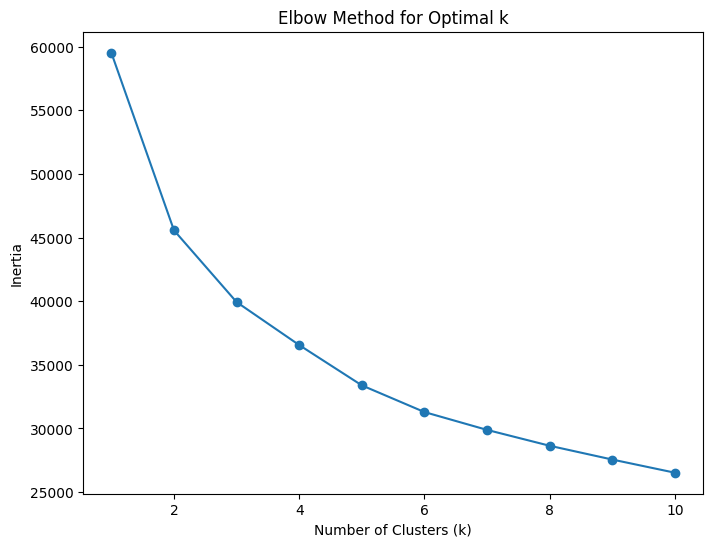

In [158]:
# Elbow Method Analysis

inertia = []
max_k = 10
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k+1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [159]:
# K-means with k = 6 based on Elbow method

k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X_combined)

data['Cluster'] = clusters

data[['joined_text', 'Cluster']]

,joined_text,Cluster
Id,,
27205,cobb skilled thief commits corporate espionage...,0
497698,natasha romanoff also known black widow confro...,0
603,set 22nd century matrix tells story computer h...,0
843794,uninhabitable 22ndcentury earth outcome civil ...,3
446893,queen poppy branch make surprising discovery —...,0
...,...,...
2749,eastern european criminals oleg emil come new ...,5
11128,watchful eye mentor captain mike kennedy proba...,5
484482,40yearold bertrand suffering depression last t...,1


#### Clusters Analysis

##### Numerical Features

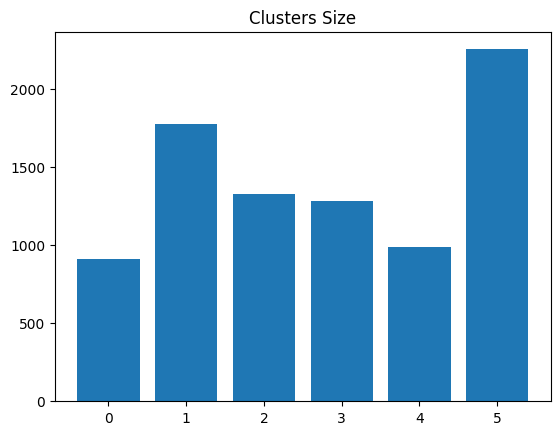

In [160]:
# Clusters size
clusters_size = data.groupby('Cluster').size()
plt.bar([0, 1, 2, 3, 4, 5], clusters_size)
plt.title('Clusters Size')
plt.show()

Note: Cluster 5 seem to have higher size than other clusters.

In [161]:
# Method to create boxplots comparing different clusters
def create_boxplots_clusters(data, column):
    sns.boxplot(x='Cluster', y=column, data=data)
    plt.title(f'{column} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

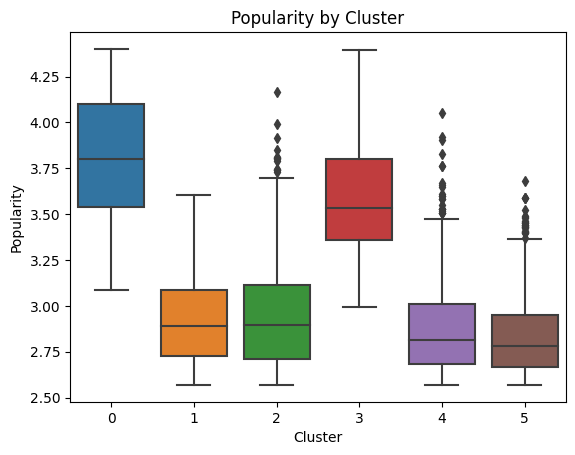

In [162]:
# Box plot of Popularity by clusters

create_boxplots_clusters(data, 'Popularity')

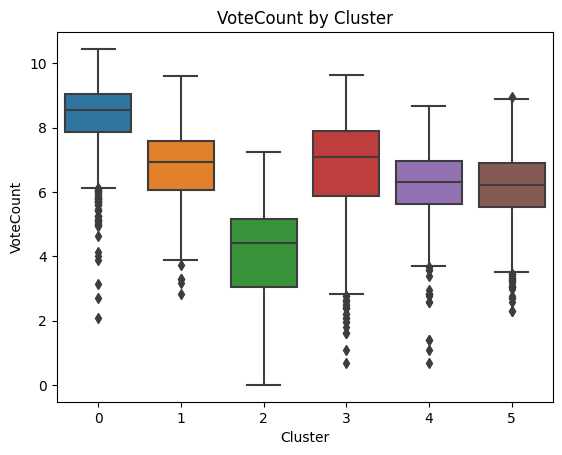

In [163]:
# Box plot of VoteCount by clusters

create_boxplots_clusters(data, 'VoteCount')

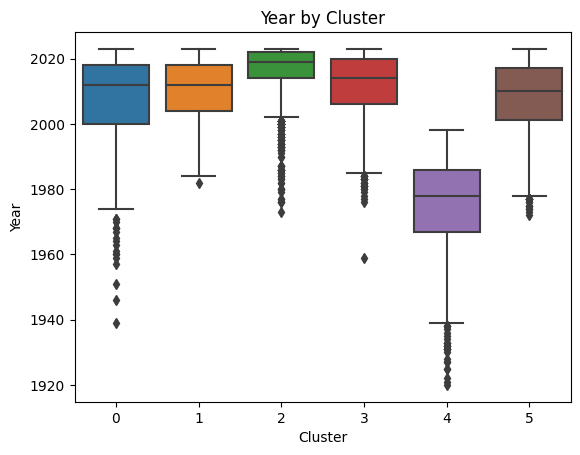

In [164]:
# Box plot of Year by clusters

create_boxplots_clusters(data, 'Year')

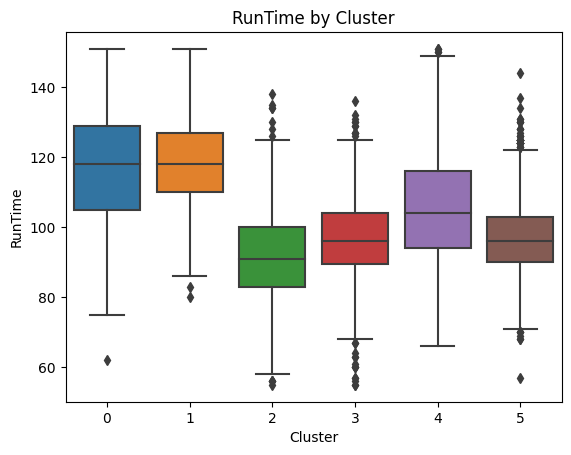

In [165]:
# Box plot of 'RunTime' by clusters

create_boxplots_clusters(data, 'RunTime')

Note:

Overall, for numerical features, there is a clear distinction between clusters, as distributions are different.

##### Textual Features

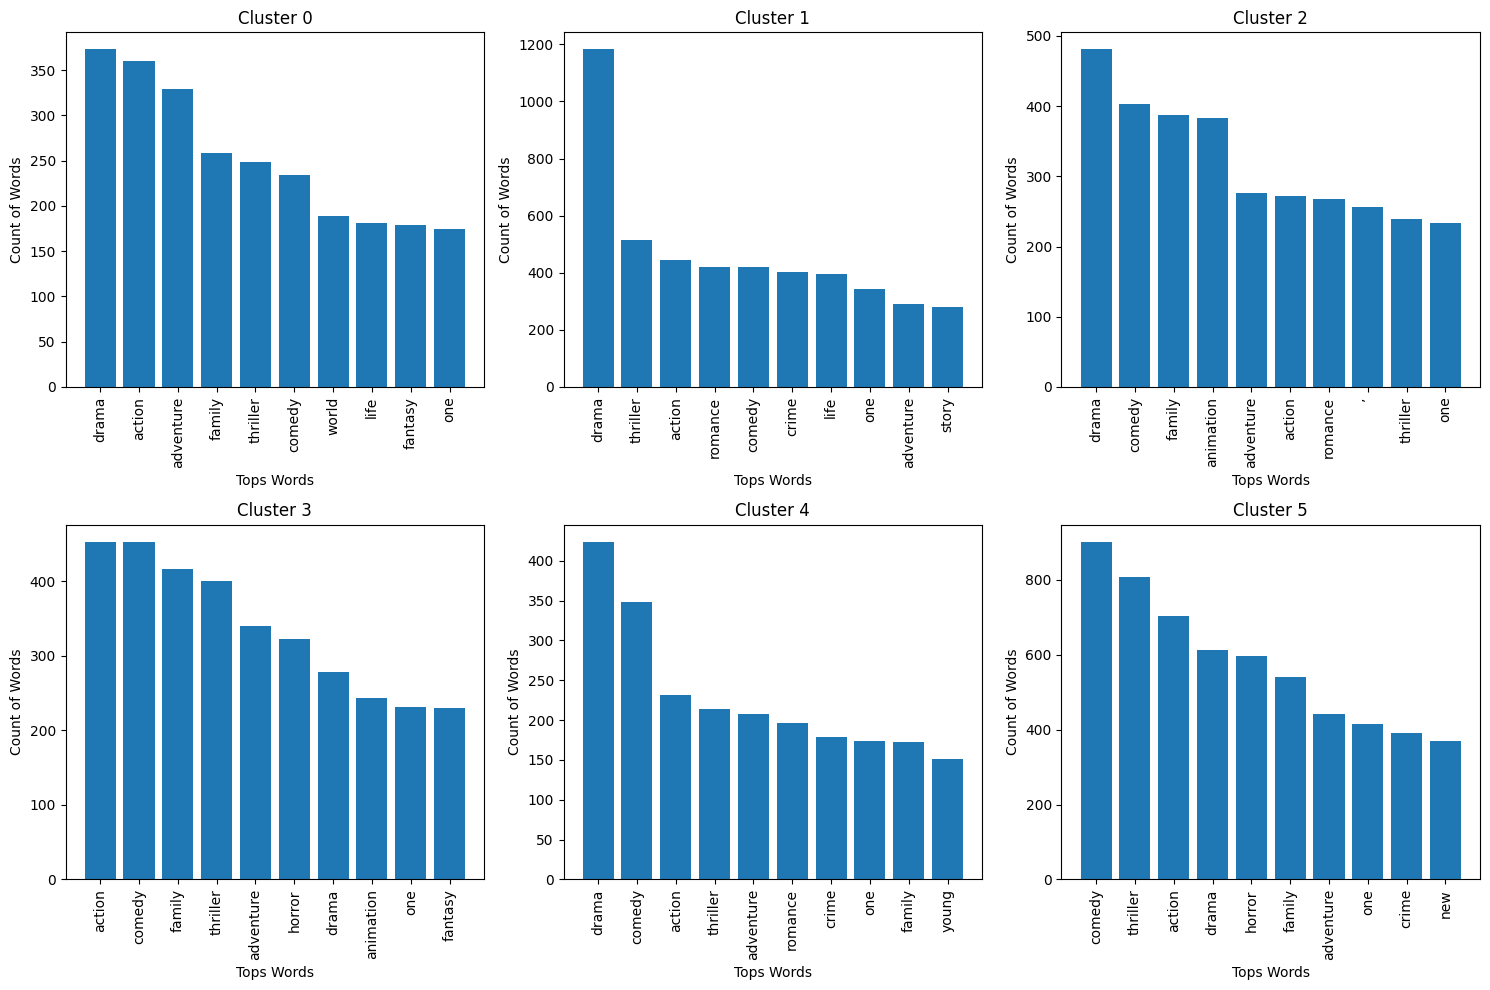

In [167]:
# Top words for each Cluster
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    # getting top words from 5 to 10, we noted that the first 5 words where mostly the genre, we want to analyse clusters without genre
    words = data.loc[data['Cluster'] == i, 'joined_text'].str.split().explode().value_counts().head(10)
    ax.bar(words.index, words.values)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Tops Words')
    ax.set_ylabel('Count of Words')
    ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Note:

In terms of textual data, the clusters were highly impacted by adding the genre column. Additionally, the most frequent words seem to be repeated from one cluster to other, which lead us to conclude that k-means may not be the best option to create clusters for the present textual data.